### Filename we're going to play with

In [2]:
filename = "data/mixedtest.csv"

In [3]:
stimuli_number = 9
response_type_list = c('during','after_1','after_2')
response_names = c('During', 'After stimuli (1) & response screen','After stimuli (2)')

In [4]:
trace_cutoff = 2 # mean dissimilarity for physically identical colours must be below this
antitrace_cutoff = 3.5 # mean dissimilarity accepted for maximally physically different colours must be above this
rt_cutoff = 700 # mean reaction times must be above this

In [5]:
exclude_noncompliant = FALSE

In [6]:
plotsubjects = FALSE
plot_within_between = FALSE
plotexpsummary = FALSE
across = FALSE
population = TRUE

### Initialisations

In [7]:
# live dangerously, get rid of pesky warnings
oldw <- getOption("warn")
options(warn = -1)

In [8]:
shhh <- suppressPackageStartupMessages # stops annoying warnings when loading libraries
library(tidyr)
library(plyr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(MASS)
library(Matrix)
library(reshape2)
library(ape) # stats
library(vegan) # stats
library(RColorBrewer)
library(cocor)
library(DescTools)
library(reshape2)
library(grid)
library(ggplotify)


Attaching package: 'tidyr'

The following object is masked _by_ '.GlobalEnv':

    population


Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine


Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select


Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Attaching package: 'reshape2'

The following object is masked from 'package:tidyr':

    smiths

Loading required package:

In [9]:
# rainbowcloud theme for plotting, stolen from: 
# https://micahallen.org/2018/03/15/introducing-raincloud-plots/?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com
raincloud_theme = theme(
text = element_text(size = 10),
axis.title.x = element_text(size = 16),
axis.title.y = element_text(size = 16),
axis.text = element_text(size = 14),
axis.text.x = element_text(angle = 45, vjust = 0.5),
legend.title=element_text(size=16),
legend.text=element_text(size=16),
legend.position = "right",
plot.title = element_text(lineheight=.8, face="bold", size = 16),
panel.border = element_blank(),
panel.grid.minor = element_blank(),
panel.grid.major = element_blank(),
axis.line.x = element_line(colour = 'black', size=0.5, linetype='solid'),
axis.line.y = element_line(colour = 'black', size=0.5, linetype='solid'))

In [10]:
# stealing ability to make flat violin plots
source("https://gist.githubusercontent.com/benmarwick/2a1bb0133ff568cbe28d/raw/fb53bd97121f7f9ce947837ef1a4c65a73bffb3f/geom_flat_violin.R")

### Functions we're going to use to do the analysis later

#### Miscellaneous

In [11]:
# get plot eccentricity labels
ploteccen <- function(datadf){
    if(datadf$Circle_1[1] == -1){
            label1 = 'Foveal'
        } else {
            label1 = 'Peripheral'
        }
        if(datadf$Circle_2[1] == -1){
            label2 = 'Foveal'
        } else {
            label2 = 'Peripheral'
        }
    return(c(label1,label2))
}

e2l <- function(eccentricity){
    if(eccentricity == -1){
        return('Foveal')
    } else {
        return('Peripheral')
    }
}

l2e <- function(eccentricity){
    if(eccentricity == 'Foveal'){
        return(-1)
    } else {
        return(1)
    }
}

#### Dissimilarity Matrices

In [12]:
# obtain dissimilarity matrices with particular eccentricity values from dataframes
dissimdata <- function(datadf, colors, eccentricity1, eccentricity2){
    # select only the eccentricities we want to keep, e.g. (foveal, foveal)
    datatemp = subset(datadf, Circle_1 == eccentricity1)
    datatemp = subset(datatemp, Circle_2 == eccentricity2)
    
    # refactor the levels so they can be plotted properly later if need be
    datatemp$Color_1 <- with(datatemp, factor(Color_1, levels = colors))
    datatemp$Color_2 <- with(datatemp, factor(Color_2, levels = colors))
    
    return(datatemp)
}

In [13]:
# plot a dissimilarity matrix
dissimplot <- function(datadf,colors,dependent='color'){
    
   # labeling the plot eccentricity comparisons
    label1 <- ploteccen(datadf)[1]
    label2 <- ploteccen(datadf)[2]
    
    
    if(dependent == 'position'){ # use position to generate matrix (as a negative control)
        plot <- ggplot(datadf, aes(x = bin1, y = bin2)) +
        theme(        axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5)) +
                      scale_x_discrete(limits=c(1,2,3,4,5,6,7,8,9)) + scale_y_discrete(limits=c(1,2,3,4,5,6,7,8,9))
    } else { # use the colors to generate the matrix
        plot <- ggplot(datadf, aes(x = Color_1, y = Color_2)) +
        theme(axis.text.x = element_text(colour = colors), axis.text.y = element_text(colour = colors),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))
    }
    # stuff that's standard across plot types
        plot <- plot + geom_raster(aes(fill = p_confidence)) +
                labs(title = paste(label1, label2, sep = " - ")) +
                scale_fill_gradientn(colours = c("white","black")) +
                guides(fill=guide_legend(title="Dissimilarity"))
    return(plot)
}

In [14]:
df2mat_asymmetry <- function(datadf,eccentricity1,eccentricity2){
    
    datadf <- dissimdata(datadf, colors, eccentricity1, eccentricity2)
    
    # aggregate over the remaining columns of interest
    nmdsdata <- aggregate(datadf, by = list(datadf$Color_1, datadf$Color_2),FUN=mean)
    nmdsdata$Color_1 <- nmdsdata$Group.1
    nmdsdata$Color_2 <- nmdsdata$Group.2

    nmdsdata = subset(nmdsdata, select = c("Color_1","Color_2","p_confidence"))  # get rid of unnecessary columns
    nmdsmatrix <- spread(nmdsdata, Color_1, p_confidence)
    # convert the dataframe to a matrix
    nmdsmatrix <- data.matrix(nmdsmatrix)
    nmdsmatrix <- nmdsmatrix[,-1] # get rid of the labels in the first column, it messes up the code
    matdf <- as.data.frame(nmdsmatrix - t(nmdsmatrix))
    matdf$colorset <- c(abcolors)
    num_colors <- length(colors)
    matdf <- matdf %>% gather(othercolor,asymmetry ,1:num_colors)
    return(matdf)
}

In [19]:
# plot an asymmetry matrix
asymmetry_plot <- function(datadf,eccentricity1,eccentricity2,colors){
    
    # labeling the types
    label1 <- "Presented"
    label2 <- "Response Screen"
    
    datadf <- df2mat_asymmetry(datadf,eccentricity1,eccentricity2)
    
    # refactor the levels so they can be plotted properly later if need be
    datadf$colorset <- with(datadf, factor(colorset, levels = colors))
    datadf$othercolor <- with(datadf, factor(othercolor, levels = colors))
    
    plot <- ggplot(datadf, aes(x = colorset, y = othercolor)) +
        theme(axis.text.x = element_text(colour = colors), axis.text.y = element_text(colour = colors),
                      axis.title.x = element_blank(), axis.title.y = element_blank(),
                      plot.title = element_text(hjust = 0.5))
    
    # stuff that's standard across plot types
        plot <- plot + geom_raster(aes(fill = asymmetry)) +
                labs(title = paste(label1, label2, sep = " - ")) +
                scale_fill_gradientn(colours = c("blue","white","red"), limits = c(-4,4)) +
                guides(fill=guide_legend(title="Dissimilarity\nAsymmetry"))
    return(plot)
}

In [34]:
testdf <- subset(datadf, subject == 809668683)

In [35]:
test_data <- dissimdata(testdf, colors, l2e('Foveal'),l2e('Foveal'))

In [36]:
dissim_test <- dissimplot(dissimdata(testdf, colors, l2e('Foveal'), l2e('Foveal')),colors)

In [37]:
asymplot_test <- asymmetry_plot(testdf,l2e('Foveal'),l2e('Foveal'),colors)


Note: Using an external vector in selections is ambiguous.
i Use `all_of(num_colors)` instead of `num_colors` to silence this message.
i See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


In [43]:
test_data

,experiment,stimuli_count,response_type,stim_display_time,stim_cue_gap,cue_display_time,subject,trial_number,Cross_position,Circle_1,...,Circle_7,Position_7,Color_7,Circle_8,Position_8,Color_8,p_confidence,response_time,bin1,bin2
10,mturkfvppilot_scaling3_time250_2stim,2,during,250,NA,NA,809668683,2,0,-1,...,NA,NA,NA,NA,NA,NA,7,2087,3,1
11,mturkfvppilot_scaling3_time250_2stim,2,during,250,NA,NA,809668683,3,0,-1,...,NA,NA,NA,NA,NA,NA,2,1877,9,4
12,mturkfvppilot_scaling3_time250_2stim,2,during,250,NA,NA,809668683,4,0,-1,...,NA,NA,NA,NA,NA,NA,5,2016,4,1
19,mturkfvppilot_scaling3_time250_2stim,2,during,250,NA,NA,809668683,11,0,-1,...,NA,NA,NA,NA,NA,NA,7,2884,9,2
24,mturkfvppilot_scaling3_time250_2stim,2,during,250,NA,NA,809668683,16,0,-1,...,NA,NA,NA,NA,NA,NA,7,889,8,1
30,mturkfvppilot_scaling3_time250_2stim,2,during,250,NA,NA,809668683,22,0,-1,...,NA,NA,NA,NA,NA,NA,7,1450,7,9
33,mturkfvppilot_scaling3_time250_2stim,2,during,250,NA,NA,809668683,25,0,-1,...,NA,NA,NA,NA,NA,NA,7,879,8,9
34,mturkfvppilot_scaling3_time250_2stim,2,during,250,NA,NA,809668683,26,0,-1,...,NA,NA,NA,NA,NA,NA,0,1168,5,2
43,mturkfvppilot_scaling3_time250_2stim,2,during,250,NA,NA,809668683,35,0,-1,...,NA,NA,NA,NA,NA,NA,7,756,9,2
45,mturkfvppilot_scaling3_time250_2stim,2,during,250,NA,NA,809668683,37,0,-1,...,NA,NA,NA,NA,NA,NA,4,2093,1,4


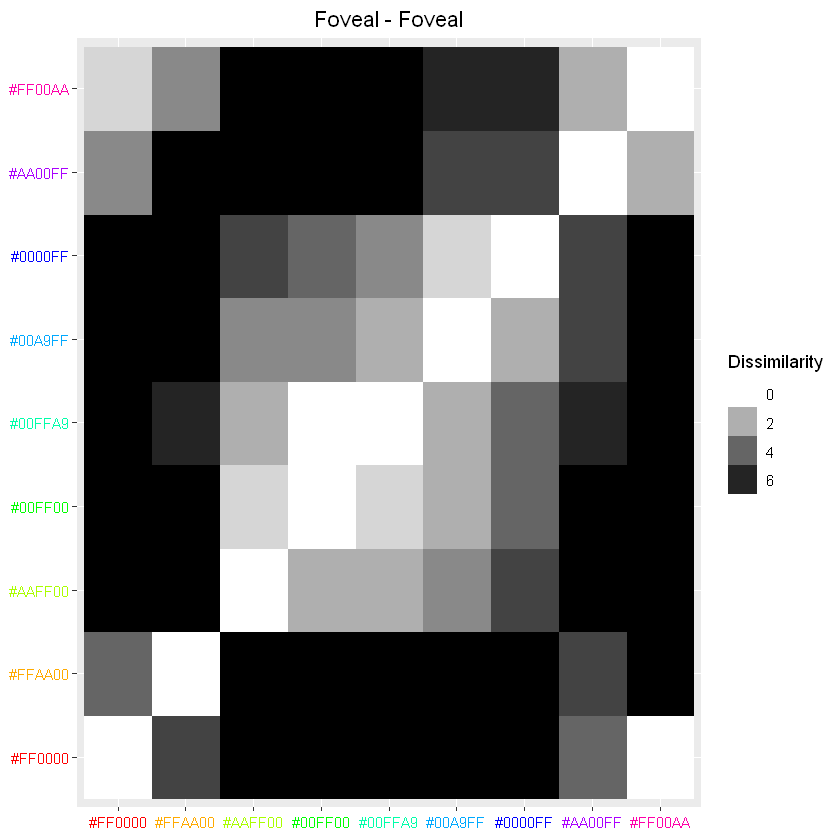

In [38]:
dissim_test

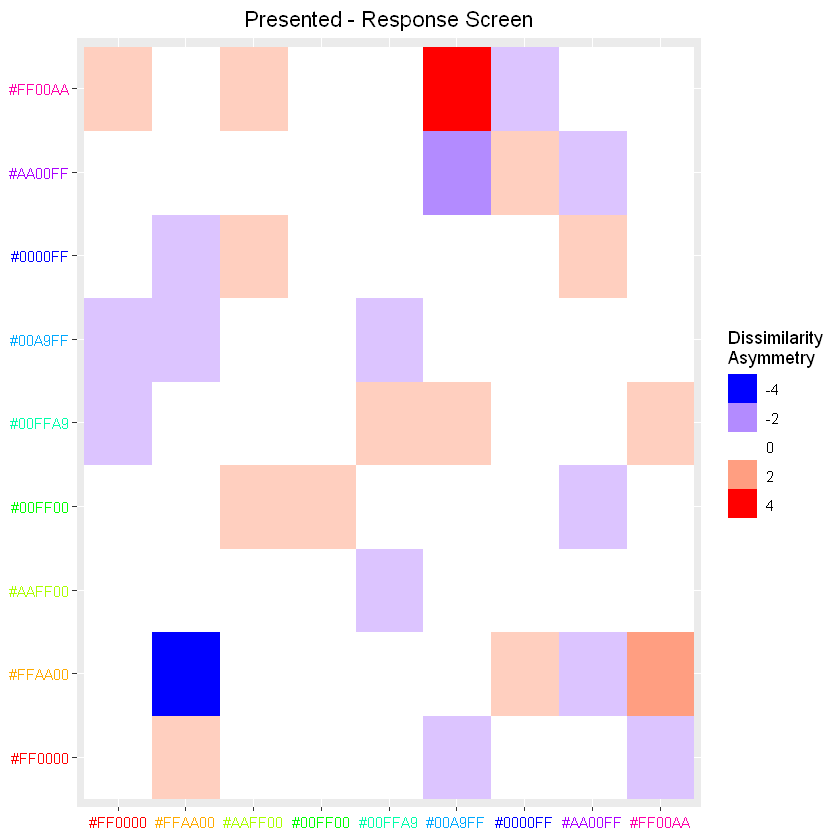

In [39]:
asymplot_test

In [15]:
# making a matrix symmetric. Stolen from dclone: https://rdrr.io/github/datacloning/dclone/src/R/make.symmetric.R
make.symmetric <-
function(x)
{
    if (dim(x)[1] != dim(x)[2])
        stop("'x' is not sqare matrix")
    rval <- t(x)
    m <- (x[lower.tri(x)] + rval[lower.tri(rval)]) / 2
    rval[lower.tri(rval)] <- m
    rval <- t(rval)
    rval[lower.tri(rval)] <- m
    rval
}

#### Multidimensional Scaling Plots

In [16]:
# turn a dataset into a matrix
df2mat <- function(datadf,eccentricity1,eccentricity2,dependent='color'){
    
    # select only the eccentricities we want to keep, e.g. (foveal, foveal)
    datadf = subset(datadf, Circle_1 == eccentricity1)
    datadf = subset(datadf, Circle_2 == eccentricity2)
    
    if(dependent == 'position'){ # using stimulus location as a negative control
        # aggregate over the remaining columns of interest
        nmdsdata <- aggregate(datadf, by = list(datadf$bin1, datadf$bin2),FUN=mean)
        nmdsdata$bin1 <- nmdsdata$Group.1
        nmdsdata$bin2 <- nmdsdata$Group.2
        
        nmdsdata = subset(nmdsdata, select = c("bin1","bin2","p_confidence"))  # get rid of unnecessary columns
        nmdsmatrix <- spread(nmdsdata, bin1, p_confidence)
    } else { # color as per normal
        # aggregate over the remaining columns of interest
        nmdsdata <- aggregate(datadf, by = list(datadf$Color_1, datadf$Color_2),FUN=mean)
        nmdsdata$Color_1 <- nmdsdata$Group.1
        nmdsdata$Color_2 <- nmdsdata$Group.2
        
        nmdsdata = subset(nmdsdata, select = c("Color_1","Color_2","p_confidence"))  # get rid of unnecessary columns
        nmdsmatrix <- spread(nmdsdata, Color_1, p_confidence)
    }
    
    # convert the dataframe to a matrix
    nmdsmatrix <- data.matrix(nmdsmatrix)
    nmdsmatrix <- nmdsmatrix[,-1] # get rid of the labels in the first column, it messes up the code
    
    # having 0 dissimilarity between identical objects messes up the algorithm
    # changing the 0 values to an arbitrarily small value, but this is not a good long-term solution
    # need to find a better way of doing this
    nmdsmatrix[nmdsmatrix == 0] <- 0.01
    
    
    nmdsmatrix <- make.symmetric(nmdsmatrix) # averaging over Color_1 vs. Color_2 & Color_2 vs. Color_1    
    return(nmdsmatrix)
}

In [17]:
# convert a standard matrix to a distance matrix
mat2dist <- function(mat){
    
    return(distmat <- as.dist(mat))
}

Non-metric multidimensional scaling (NMDS)

In [18]:
# find the nmds fit for a dataset
nmdsfit <- function(distmatrix){
      
    fit <- isoMDS(distmatrix,k=2, maxit=100)
    return(fit)
}

In [19]:
# plot the nmds fit
nmdsplot <- function(fit, colors, abcolors, eccentricity1, eccentricity2){
    
    # get labels
    
    # change the nmdsfit back to a dataframe
    nmdsdf <- as.data.frame(fit)
    
    plot <-     ggplot(nmdsdf, aes(x = points.1, y = points.2, color=colors, fill=colors)) + geom_point(size =10) + 
                scale_colour_manual(values = abcolors) + scale_fill_manual(values = abcolors) + 
                xlab("Dimension 1") + ylab("Dimension 2") + 
                ggtitle(paste(e2l(eccentricity1),e2l(eccentricity2),'Non-metric MDS',sep=' - '))
    return(plot)
}

Classical multidimensional scaling

In [20]:
# find the cmds fit for a dataset
cmdsfit <- function(distmatrix){
    
    fit <- cmdscale(distmatrix,k=2)
    return(fit)
}

In [21]:
# plot the cmds fit
cmdsplot <- function(fit, colors, abcolors, eccentricity1, eccentricity2){
    
    # get labels
    
    # change the nmdsfit back to a dataframe
    nmdsdf <- as.data.frame(fit)
    
    plot <-     ggplot(nmdsdf, aes(x = V1, y = V2, color=colors, fill=colors)) + geom_point(size =10) + 
                scale_colour_manual(values = abcolors) + scale_fill_manual(values = abcolors) + 
                xlab("Dimension 1") + ylab("Dimension 2") + 
                ggtitle(paste(e2l(eccentricity1),e2l(eccentricity2),'Classical MDS',sep=' - '))
    return(plot)
}

#### Some control measure plots

Reaction time vs. similarity judgements

In [204]:
# similarity judgement histogram
simhistplot <- function(datadf){
    
   plot <- ggplot(datadf, aes(x = p_confidence)) + geom_bar(aes(y = ..prop..)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') +
    ylab('Frequency') + ylim(0,0.8)
    return(plot)
}

simhistplot_summary <- function(datadf){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    plot <- ggplot(datadf, aes(x = p_confidence)) + 
    geom_line(stat='count',aes(y = ..prop..,group = subject),color='#CC9933') +
    geom_line(stat='count',aes(y = ..prop..),size=1.5) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') +
    ylab('Frequency') + ylim(0,0.8)
    return(plot)
    
}

In [135]:
# reaction time for each similarity
rsplot <- function(datadf){
    
    plot <- ggplot(datadf, aes(x= p_confidence, y=response_time)) + 
    stat_summary(fun.y = mean, geom = "bar") + 
    stat_summary(fun.data = mean_se, geom = "errorbar", size =0.5, aes(width=0.5)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') + ylab('Reaction Time (ms)') +
    theme(legend.position = "none") +
    ylim(0,4000) # anyone taking more than 4 seconds has probably mindwandered
    
    return(plot)
}

rsplot_summary <- function(datadf){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    
    
    plot <- ggplot(datadf, aes(x= p_confidence, y=response_time,group = subject, color = subject)) + 
    stat_summary(fun.y = mean, geom = "line", size=0.8) + 
    #stat_summary(fun.data = mean_se, geom = "errorbar", size =0.5, aes(width=0.5)) +
    scale_x_discrete(limits=c(0,1,2,3,4,5,6,7), name = 'Dissimilarity') + ylab('Mean Reaction Time (ms)') +
    theme(legend.position = "none") +
    ylim(0,4000) # anyone taking more than 4 seconds has probably mindwandered 
    
    return(plot)
    
}

In [24]:
# reaction time raincloud plot
rsplot_raincloud <- function(datadf,xtype='linear'){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation  
    datadf$p_confidence <- as.character(datadf$p_confidence) # necessary for visualisation
    
    ylabtext = 'Reaction Time (ms)'
    
    plot <- ggplot(datadf, aes(y = response_time, x = p_confidence, fill = p_confidence)) +
            geom_flat_violin(position = position_nudge(x = .2, y = 0), alpha = .8) +
            geom_point(aes(y = response_time, color = p_confidence),
                   position = position_jitter(width = .15), size = .5, alpha = 0.8) +
            geom_boxplot(width = .1, guides = FALSE, outlier.shape = NA, alpha = 0.5) +
            expand_limits(x = 5.25) +
            guides(fill = FALSE) +
            guides(color = FALSE) +
            scale_color_brewer(palette = "Spectral") +
            scale_fill_brewer(palette = "Spectral") +
            xlab('Dissimilarity') + ylab("Reaction Time (ms)")
            # coord_flip() +
            theme_bw() +
            raincloud_theme
    
    if(xtype == 'log'){
        plot <- plot + scale_y_continuous(trans='log10')
    } else{
        plot <- plot + ylim(0,5000)
    }
    
    return(plot)
}

In [321]:
# correlation between reaction times and similarity judgements
# grouping at individual trial, individual participant, experiment or entire population level
rt_similarity_cor <- function(datadf,level='participant'){
        
    if(level=="participant"){
        datadf <- datadf %>% 
                group_by(subject) %>% 
                mutate(rt_similarity_correlation = cor(p_confidence,response_time))
        datadf <- aggregate(datadf, by=list(datadf$subject), FUN = mean)

                
    }
    return(datadf)
    
}

rt_similarity_plot <- function(datadf,xlabel='BLANK'){
    
    datadf <- rt_similarity_cor(datadf)
    
    datadf[xlabel] = xlabel
    
    plot <- ggplot(datadf,aes(x=xlabel,y=rt_similarity_correlation)) + 
                geom_boxplot() + 
                geom_dotplot(binaxis='y',stackdir='center',dotsize=0.75) +
                theme(text = element_text(size=15)) + xlab("")
                ggtitle(title)
    
    plot <- plot + ylab("Correlation (Spearman)") + ylim(-1,1)
    plot <- plot + geom_hline(yintercept=0, linetype="dashed", color = "blue")
    return(plot)
}

In [372]:
# mean reaction time vs. antitrace-trace difference
rt_difference <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for(ID in subjectlist){
        tempdf <- subset(datadf, subject == ID)
        datadf$difference[datadf$subject == ID] = unlist(antitrace_avg(tempdf),use.names=FALSE)[1] - 
                   unlist(trace_avg(tempdf),use.names=FALSE)[1]
    }
        datadf <- aggregate(datadf, by=list(datadf$subject), FUN = mean)
    return(datadf)
}

rt_difference_plot <- function(datadf,xtype='linear'){
    
    plot <- ggplot(rt_difference(datadf), aes(x=response_time, y=difference)) +
            geom_point() + xlab("Mean Reaction Time") + ylab("Antitrace - Trace")
    
    if(xtype == 'log'){
        plot <- plot + scale_x_continuous(trans='log10')
    } else{
        plot <- plot + xlim(0,5000)
    }
    plot <- plot + geom_smooth(method=lm) # linear line of best fit
    return(plot)
}

In [457]:
# trace values vs. trial #
trace_by_trial_plot <- function(datadf,graph='point',mode='relative'){
    
     datadf$subject <- as.character(datadf$subject) # necessary for visualisation  
    
    datadf <- subset(datadf, Color_1 == Color_2)
    
    if(mode=='relative'){
        datadf <- datadf %>% group_by(subject) %>% mutate(trialnum = row_number())
    } else{
        datadf$trialnum <- datadf$trial_number
    }
        
    if(graph=='point'){
        plot <- ggplot(datadf, aes(x=trialnum, y = p_confidence, group = subject, color = subject)) + geom_point()
    } else if (graph == 'boxplot'){
        plot <- ggplot(datadf, aes(x=trialnum,y = p_confidence, group = trialnum)) + geom_boxplot() #????
    } else if (graph == 'lineplot'){
        plot <- ggplot(datadf, aes(x=trialnum, y = p_confidence,group=subject, color = subject)) + geom_line()
    }
    
    plot <- plot + ylab('Dissimilarity') +  theme(legend.position='none')
    
    return(plot)
    
}

In [25]:
# subject info
sumplot <- function(datadf){
    
    # change ms to s, add the delay for each trial
    datadf$response_time <- ((datadf$response_time + 0.125*nrow(datadf)) / 1000)
    
    plot <- ggplot(datadf, aes(x=subject, y = response_time)) + 
    stat_summary(fun.y = sum, geom = "bar") + ylim(0,1000) +
    ylab('Response Time Total') + theme(axis.title.x=element_blank(), axis.text.x = element_text(size=20))
    
    return(plot)
}

### Statistics

Useful functions

In [26]:
# compare the foveal and peripheral matrices to each other
fvp_test <- function(datadf,dependent='color'){
    
    if(dependent=='position'){
        # first, turn the dataframe into the relevant matrices
        fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'),'position')
        #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
        pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'),'position')
    } else{
        # first, turn the dataframe into the relevant matrices
        fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'))
        #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
        pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'))
    }
    #Fovea vs Periphery
    test <- mantel(fmatrix, pmatrix, method="spearman",permutations = 9999)
    return(test)
}

In [27]:
# compare the each of the foveal and peripheral matrices to a random uniform distribution using a ... test
# not actually sure this is conceptually possible or even makes sense
rand_test <- function(datadf){
    
    # first, turn the dataframe into the relevant matrices
    fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'))
    #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
    pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'))
    
    
    # compare
    ftest <- 
    ptest <- 
    return(list("ftest" = ftest, "ptest" = ptest)) # use index of result to get the foveal or peripheral comparison
}



In [28]:
# calculate trace average, small values presumably indicate subjects not just saying everything is completely dissimilar
# will also need a complementary method to deal with them saying everything is the same? Might be an inappropriate
# a-priori imposition though, I probably can't tell people how similar different colours should be...

trace_avg <- function(datadf){
    
    # first, turn the dataframe into the relevant matrices
    fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'))
    #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
    pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'))
    
    
    
    return(list( (sum(diag(fmatrix))/nrow(fmatrix)), (sum(diag(pmatrix))/nrow(pmatrix))))
}

In [29]:
# find the 'anti-trace' of a matrix
antitrace <- function(mat){
    
    sum = 0
    for(i in (1:nrow(mat))){
        k = as.numeric(mat[ i, as.integer((ncol(mat)/2+i) %% ncol(mat))+1 ])
        sum = sum + k
    }
    return(sum/nrow(mat))
}

In [30]:
# calculates the average of the 'anti-trace', the values I'd expect to be the most dissimilar.
# this may not be an appropriate imposition on subjects...

antitrace_avg <- function(datadf){
    
    # first, turn the dataframe into the relevant matrices
    fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'))
    #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
    pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'))
    
    return(list(antitrace(fmatrix), antitrace(pmatrix)))
}

In [31]:
# just get a simple measure of if the matrices are correlated, irrespective of treating them as distance matrices
matrixcor <- function(datadf,dependent='color'){
    
    if(dependent == 'position'){
        # first, turn the dataframe into the relevant matrices
        fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'),'position')
        #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
        pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'),'position')
    } else {
        # first, turn the dataframe into the relevant matrices
        fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'))
        #fpmatrix <- distmatrix(datadf, l2e('Foveal'), l2e('Peripheral'))
        pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'))
    }
    
    return(cor(c(fmatrix), c(pmatrix), method = "spearman"))
}

In [32]:
# get median reaction time
rt_avg <- function(datadf){
    return(median(datadf$response_time))
}

Run the analysis

In [33]:
# stats for all the subjects
allsubjectstats <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects


    for (subjectid in subjectlist){
        
        subjectdf = subset(datadf, subject == subjectid) # select the df for subject of interest
        cat("SUBJECT: ",subjectid,'\n') # print subject id
        print("Mantel Test: ")
        print(fvp_test(subjectdf))
        print("Matrices correlation: ")
        print(matrixcor(subjectdf))
        print("Quality control measures:")
        print("Trace average:")
        print(trace_avg(subjectdf))
        print("Anti-trace average:")
        print(antitrace_avg(subjectdf))
    }
}

In [34]:
# function to aggregate everyone's data together
aggregate_df <- function(datadf,dependent='color'){

    # aggregate everyone's data together for the matrices
    everyonedata <- aggregate(datadf, by=list(
        datadf$Color_1,
        datadf$Color_2,
        datadf$Circle_1,
        datadf$Circle_2,
        datadf$bin1,
        datadf$bin2
        ), FUN=mean, 
    )

    # correct the column names
    everyonedata$Color_1 <- everyonedata$Group.1
    everyonedata$Color_2 <- everyonedata$Group.2
    everyonedata$Circle_1 <- everyonedata$Group.3
    everyonedata$Circle_2 <- everyonedata$Group.4
    everyonedata$bin1 <- everyonedata$Group.5
    everyonedata$bin2 <- everyonedata$Group.6
    
    return(everyonedata)
}

In [35]:
# compliance checker
compliance_checker <- function(datadf,eccentricity,trace_cutoff,antitrace_cutoff){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    n_subject = length(subjectlist)
    trace_fail = 0
    antitrace_fail = 0
    
    if(eccentricity == 'Foveal'){
        e_ind = 1
    } else if (eccentricity == 'Peripheral'){
        e_ind = 2
    }

    for (subjectid in subjectlist){
        subjectdf = subset(datadf, subject == subjectid) # select the df for subject of interest
        if(trace_avg(subjectdf)[e_ind] > trace_cutoff){
            trace_fail = trace_fail + 1
        }
        if(antitrace_avg(subjectdf)[e_ind] < antitrace_cutoff){
            antitrace_fail = antitrace_fail + 1
        }
    }
    print(paste("Trace non-compliance: ",trace_fail,"/",n_subject))
    print(paste("Anti-trace non-compliance: ",antitrace_fail,"/",n_subject))
}

In [36]:
# summary stats
summarystats <- function(datadf,dependent='color'){
    if(dependent=='position'){
        print("Mantel Test: ")
        print(fvp_test(aggregate_df(datadf),'position'))
        print("Matrices correlation: ")
        print(matrixcor(aggregate_df(datadf),'position'))
    } else {
        print("Mantel Test: ")
        print(fvp_test(aggregate_df(datadf)))
        print("Matrices correlation: ")
        print(matrixcor(aggregate_df(datadf)))
    }
    
    
    print("Foveal compliance:")
    compliance_checker(datadf,'Foveal')
    print("Peripheral compliance:")
    compliance_checker(datadf,'Peripheral')
}

## Actual Data Analysis Time

#### Initial data pre-processing, before getting to the subject level

In [27]:
datadf = read.csv(filename)
savestr <- substr(filename,1,nchar(filename)-4) # for saving related files later


In [28]:
# remove practice trial data
datadf <- subset(datadf, trial_number != 0)

In [29]:
# changing color values from RGB to hex for graphing purpose
datadf$Color_1 <- as.character(datadf$Color_1)
datadf$Color_1 <- revalue(datadf$Color_1, 
                                                    c(  "1" = '#FF0000',
                                                        "2" = '#FFAA00',
                                                        "3" = '#AAFF00',
                                                        "4" = '#00FF00',
                                                        "5" = '#00FFA9',
                                                        "6" = '#00A9FF',
                                                        "7" = '#0000FF',
                                                        "8" = '#AA00FF',
                                                        "9" = '#FF00AA'))
datadf$Color_2 <- as.character(datadf$Color_2)
datadf$Color_2 <- revalue(datadf$Color_2, 
                                                    c(  "1" = '#FF0000',
                                                        "2" = '#FFAA00',
                                                        "3" = '#AAFF00',
                                                        "4" = '#00FF00',
                                                        "5" = '#00FFA9',
                                                        "6" = '#00A9FF',
                                                        "7" = '#0000FF',
                                                        "8" = '#AA00FF',
                                                        "9" = '#FF00AA'))

# colors for the labels
colors <- c('#FF0000','#FFAA00','#AAFF00','#00FF00','#00FFA9','#00A9FF','#0000FF','#AA00FF','#FF00AA')
abcolors <- sort(colors)

In [30]:
# changing from int indicators in the .csv file to more readable labels for eccentricity
foveal = -1
peripheral = 1

In [31]:
# set the maximum and minimum dissimilarity values for later analysis
min_val = 0
max_val = 6

In [32]:
# binning the positions the stimuli were displayed in to use as a control measure later
datadf$bin1 <- as.integer((datadf$Position_1+180) / 40) + 1
datadf$bin2 <- as.integer((datadf$Position_2+180) / 40) + 1

In [33]:
# adding a trial type label
label_eccen_type <- function(datadf){
    datadf <- datadf %>%
    mutate(trial_type = case_when(Circle_1 == l2e('Foveal') & Circle_2 == l2e('Foveal') ~ 'FF',
                             Circle_1 == l2e('Foveal') & Circle_2 == l2e('Peripheral') ~ 'FP',
                             Circle_1 == l2e('Peripheral') & Circle_2 == l2e('Peripheral') ~ 'PP'))
    return(datadf)
}

In [22]:
datadf <- label_eccen_type(datadf)

Some actual data cleaning

In [23]:
# function to throw out  participants who didn't finish
remove_incomplete <- function(datadf,stimuli_number){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for (ID in subjectlist){ # go through subject by subject
        if(as.character(datadf$response_type[1])=='after_1'){
            trialnumber = stimuli_number*stimuli_number*2 #F to response, P to response
        } else {
            trialnumber = stimuli_number*stimuli_number*3 #FF, FP, PP
        }
        if ( nrow(subset(datadf, subject == ID)) != trialnumber){ # see if they have the appropriate trial numbers
            print(paste("Subject",ID,"did not complete the task",sep=' '))
            datadf <- subset(datadf, subject != ID) # dump the subject
        }
    }
    return(datadf)
}

In [46]:
# actually throw out the subjects who didn't complete
datadf <- remove_incomplete(datadf,stimuli_number)

[1] "Subject 6012932 did not complete the task"
[1] "Subject 224000648 did not complete the task"
[1] "Subject 260546310 did not complete the task"
[1] "Subject 285547937 did not complete the task"
[1] "Subject 350715044 did not complete the task"
[1] "Subject 373747035 did not complete the task"
[1] "Subject 480971640 did not complete the task"
[1] "Subject 593249113 did not complete the task"
[1] "Subject 613876179 did not complete the task"
[1] "Subject 648596732 did not complete the task"
[1] "Subject 773122519 did not complete the task"
[1] "Subject 789422609 did not complete the task"
[1] "Subject 814700919 did not complete the task"
[1] "Subject 880753199 did not complete the task"
[1] "Subject 893284757 did not complete the task"
[1] "Subject 905952052 did not complete the task"
[1] "Subject 908241720 did not complete the task"
[1] "Subject 917271466 did not complete the task"
[1] "Subject 945283206 did not complete the task"


In [47]:
# function to label participants who meet statistical cleaning assumptions
label_noncompliant <- function(datadf,eccentricity,
                               trace_cutoff=2,antitrace_cutoff=4,rt_cutoff=1000){
    
    if(eccentricity == 'Foveal'){
        e_ind = 1
    } else if (eccentricity == 'Peripheral'){
        e_ind = 2
    }
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    for (ID in subjectlist){ # go through subject by subject
        subjectdf = subset(datadf, subject == ID) # select the ID for subject of interest 
        if(trace_avg(subjectdf)[e_ind] < trace_cutoff){
            if(antitrace_avg(subjectdf)[e_ind] > antitrace_cutoff){
                if(rt_avg(subjectdf) > rt_cutoff){
                    datadf$noncompliant[datadf$subject == ID] = 0
                } else {
                    print(paste("Subject",ID,"median reaction time of:",rt_avg(subjectdf),"ms",sep=' '))
                    datadf$noncompliant[datadf$subject == ID] = 1
                }
            } else {
                print(paste("Subject",ID,"had an antitrace of:",antitrace_avg(subjectdf)[e_ind],sep=' '))
                datadf$noncompliant[datadf$subject == ID] = 2
            }
        } else {
            print(paste("Subject",ID,"had a trace of:",trace_avg(subjectdf)[e_ind],sep=' '))
            datadf$noncompliant[datadf$subject == ID] = 3
        }
    }
    print(paste(length(unique(datadf$subject[datadf$noncompliant==0])),"of",length(unique(datadf$subject)),
                "were compliant",sep=' '))
    return(datadf)
}

In [48]:
datadf <- label_noncompliant(datadf,'Foveal')

[1] "Subject 2989630 had a trace of: 3.22666666666667"
[1] "Subject 3478854 had a trace of: 3.44444444444444"
[1] "Subject 13811877 had a trace of: 3.22222222222222"
[1] "Subject 36190138 had a trace of: 2.33333333333333"
[1] "Subject 37316066 had a trace of: 2.66777777777778"
[1] "Subject 42436095 had a trace of: 2.56111111111111"
[1] "Subject 51602224 had a trace of: 4.66666666666667"
[1] "Subject 56511823 had an antitrace of: 3.94444444444444"
[1] "Subject 69616059 had a trace of: 2.66888888888889"
[1] "Subject 69621683 had a trace of: 2.44444444444444"
[1] "Subject 84511979 had a trace of: 4.33555555555556"
[1] "Subject 93458386 had an antitrace of: 3.77777777777778"
[1] "Subject 100042706 had a trace of: 3.11333333333333"
[1] "Subject 102294477 had an antitrace of: 2.83444444444444"
[1] "Subject 103557621 median reaction time of: 750 ms"
[1] "Subject 114423889 had a trace of: 5.33333333333333"
[1] "Subject 129877772 had a trace of: 4.11111111111111"
[1] "Subject 137230626 median r

## Statistical Analysis

#### Determine within-subject central and peripheral QDM correlation & significance

In [50]:
# return a list of the fovea matrix vs periphery matrix correlations for each subject

fvp_list <- function(datadf){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    correlation_list <- vector() # array to store the values in
    
    for (ID in subjectlist){ # go through subject by subject
        subjectdf = subset(datadf, subject == ID) # select the ID for subject of interest
        correlation_list <- c(correlation_list, (matrixcor(subjectdf)))
    }
    return(correlation_list)
}

In [51]:
# shuffle the rows of a matrix
shuffle_matrix <- function(matrix){
    shuffled <- matrix[sample(nrow(matrix)),]
    return(shuffled)
}

In [52]:
# return a list of the fovea matrix vs. shuffled periphery matrix for each subject. Pick the # shuffles, default 1000.
# returns Fisher-transformed correlations

fvp_shuffled_list <- function(datadf, shuffle_num=1000){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    
    correlation_list <- vector() # array to store the values in
    
    for (ID in subjectlist){ # go through subject by subject
        subjectdf = subset(datadf, subject == ID) # select the ID for subject of interest
        
        fmatrix <- df2mat(datadf, l2e('Foveal'), l2e('Foveal'))
        pmatrix <- df2mat(datadf, l2e('Peripheral'), l2e('Peripheral'))
        
        temp_list <- vector()
        for (i in 1:shuffle_num){ #shuffle the peripheral matrix, add values to temp list
            pmatrix_shuffled <- shufflematrix(pmatrix)
            temp_list <- c(temp_list, FisherZ(cor(c(fmatrix), c(pmatrix_shuffled), method = "spearman")))
        }
        
        correlation_list <- c(correlation_list,mean(temp_list)) # add the average correlation to the list
        }
    return(correlation_list)
}

In [53]:
# perform Mann-Whitney U test to compare the within-subject central and peripheral QDMs to randomly shuffled ones
within_subject_test <- function(original_correlations,shuffled_correlations){
    
    wilcox.test(original_correlations,shuffled_correlations)
}

In [54]:
# do the analysis

#### Determine between-subject central to central QDM correlation & significance

In [55]:
# obtain the subject similarity matrix
i_j_list <- function(datadf, eccentricity1=l2e('Foveal'), eccentricity2=l2e('Foveal')){
    
    datadf = subset(datadf, Circle_1 == eccentricity1)
    datadf = subset(datadf, Circle_2 == eccentricity2)
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    
    correlation_list <- vector() # array to store the values in
    
    for (ID_i in subjectlist){ 
        for (ID_j in subjectlist){
            if(ID_i != ID_j){
                subjectdf_i = subset(datadf, subject == ID_i)
                subjectdf_j = subset(datadf, subject == ID_j)

                fmatrix_i <- df2mat(subjectdf_i, l2e('Foveal'), l2e('Foveal')) # get their fovea dissimilarity matrix
                fmatrix_j <- df2mat(subjectdf_j, l2e('Foveal'), l2e('Foveal')) # get their fovea dissimilarity matrix

                correlation_list <- c(correlation_list, cor(c(fmatrix_i), c(fmatrix_j), method = "spearman"))
                }
        }
    }
    return(correlation_list)
}

In [56]:
# obtain a shuffled subject similarity matrix

In [57]:
# test where the correlation of the original SSM sits in comparison to the shuffled SSMs

In [58]:
# do the analysis

#### Determine whether within-subject central-peripheral QDM correlation is equal to or greater than between-subject central-central QDMs

In [59]:
# blah

In [60]:
# do the analysis

In [121]:
# correlation plot
corr_plot <- function(correlation_list,title='BLANK',xlabel='BLANK',f2z=FALSE){
    df <- data.frame(correlation_list) # convert list to data frame
    df[xlabel] = xlabel
    
    plot <- ggplot(df,aes(x=xlabel,y=correlation_list)) + 
                geom_boxplot() + 
                geom_dotplot(binaxis='y',stackdir='center',dotsize=0.75) +
                theme(text = element_text(size=15)) + xlab("")
                ggtitle(title)
    if(f2z){
                plot <- plot + ylab("Fisher-Transformed Correlation (Spearman)") + ylim(-1,2)
    } else {
                plot <- plot + ylab("Correlation (Spearman)") + ylim(-0.5,1)

    }
    plot <- plot + geom_hline(yintercept=0, linetype="dashed", color = "blue")
    return(plot)
}

In [62]:
within_between_plots <- function(datadf,savestr){
    
    fvp <- fvp_list(datadf)
    i_j <- i_j_list(datadf)
    
    within_plot <- corr_plot(fvp,'Within-subject FvP','Within-subject FvP')
    between_plot <- corr_plot(i_j,'Between-subject FvF','Between-subject FvF')
    within_plot_fisher <- corr_plot(FisherZ(fvp),'Within-subject FvP','Within-subject FvP',TRUE)
    between_plot_fisher <- corr_plot(FisherZ(i_j),'Between-subject FvF','Between-subject FvF',TRUE)

    # save the plots
    title <- textGrob(substr(savestr,nchar('data/')+1,nchar(savestr)))
    g <- arrangeGrob(within_plot,between_plot,
                     within_plot_fisher,between_plot_fisher,
                        nrow = 2, ncol= 2,
                    top = title)

        # save it
    ggsave(paste(savestr,"_Subject_Plots/","correlation plot comparisons_","plot.png",sep=''),g, height = 11, width = 10)
}

In [63]:
# plot within-subject FvP correlations against between-subject FvF correlations
if(plot_within_between){within_between_plots(datadf,savestr)}

Additional experimental summary graphs

In [64]:
# obtains a dataframe of traces for subjects
trace_obtainer <- function(datadf,type="trace"){
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects
    tracedf <- data.frame(subject=character(),ftrace=double(),ptrace=double()) # initialise an output df for the traces
    for (ID in subjectlist){
        tempdf <- subset(datadf, subject == ID)
        if(type == 'antitrace'){
            subject_trace <- antitrace_avg(tempdf)
        } else if (type == 'difference'){
            subject_trace <- unlist(antitrace_avg(tempdf),use.names=FALSE) - unlist(trace_avg(tempdf),use.names=FALSE)
        }else{
            subject_trace <- trace_avg(tempdf)
        }
        row_df <- data.frame(ID, as.numeric(subject_trace[1]),as.numeric(subject_trace[2]))
        names(row_df) <- c("subject","Fovea x Fovea","Periphery x Periphery")
        tracedf<- rbind(tracedf,row_df)
    }
    return(tracedf)
}

In [107]:
# plot the traces for the subjects individually
trace_plot <- function(datadf,type='trace',grouped=TRUE){
    
    datadf$subject <- as.character(datadf$subject) # necessary for visualisation
    
    if(type == 'antitrace'){
        trace_df <- trace_obtainer(datadf,'antitrace')
    } else if (type == 'difference'){
        trace_df <- trace_obtainer(datadf,'difference')
    } else {
        trace_df <- trace_obtainer(datadf)
    }
    
    
    tracedf <- gather(trace_df, key = "eccentricity",value = "trace", 2:3)
    
    if(grouped){
        plot <- ggplot(tracedf, aes(x = eccentricity, y=trace)) +
        geom_boxplot() + geom_dotplot(binaxis='y',stackdir='center',dotsize=0.5) +
        theme(legend.position = "none")
    } else {
        plot <- ggplot(tracedf, aes(x = eccentricity, y=trace, group = subject, color = subject)) +
        geom_line() + theme(legend.position = "none")
    }
    
    if(type == 'antitrace'){
        plot <- plot + ylim(0,7) + ylab("Mean Physically Maximally Distinct Stimulus Similarity")
    } else if (type == 'difference'){
        plot <- plot + ylim(-6,6) + ylab("Distinct - Identical")
    } else {
        plot <- plot + ylim(0,7) + ylab("Mean Physically Identical Stimulus Similarity")
    }
    
    return(plot)
}

### Plot summary of all subjects

#### Individual subjects

In [66]:
# plot summary data for all the subjects individually
allsubjectsplot <- function(datadf,savestr){
    
    subjectlist <- sort(unique(datadf$subject)) # obtain a list of all the subjects

    dir.create(paste(savestr,"Subject_Plots",sep='_')) # make a new folder to store the subject plots in

    for (subjectid in subjectlist){
        print(paste("Processing subject:",subjectid,sep=' '))
        subjectplot(datadf, subjectid,savestr)
    }
}

In [110]:
# make a plot of the key summary data for a subject
subjectplot <- function(datadf, subjectid,savestr){
    
    subjectdf = subset(datadf, subject == subjectid) # select the ID for subject of interest
    
    if(subjectdf$response_type[1] != 'after_1'){
        FP = TRUE
    } else {
        FP = FALSE
    }
    
    # FF Matrix plot
    FFmatrix <- dissimplot(dissimdata(subjectdf, colors, l2e('Foveal'), l2e('Foveal')),colors)
    
    
    
    # PP Matrix plot
    PPmatrix <- dissimplot(dissimdata(subjectdf, colors, l2e('Peripheral'), l2e('Peripheral')),colors)
    
    # FF CMDS plot
    FFcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(subjectdf,l2e('Foveal'), l2e('Foveal')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))
    
    
    
    # PP CMDS plot
    PPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(subjectdf,l2e('Peripheral'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))
    
    # FF nMDS plot
    FFnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(subjectdf,l2e('Foveal'), l2e('Foveal')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))
    
    
    
    # PP nMDS plot
    PPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(subjectdf,l2e('Peripheral'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))
    
    # Similarity judgements
    simplot <- simhistplot(subjectdf)
    # Reaction times
    reactionplot <- rsplot(subjectdf)
    # summary plot
    rainplot <- rsplot_raincloud(subjectdf,'log')
    
    # trace plots
    traceplot <- trace_plot(subjectdf)
    antiplot <- trace_plot(subjectdf,'antitrace')
    differenceplot <- trace_plot(subjectdf,'difference')
    
    # asymmetry plot
    asymplot <- asymmetry_plot(subjectdf,l2e('Foveal'),l2e('Foveal'),colors)
    
    # title
    if(subjectdf$noncompliant[1]){
        title <- textGrob(as.character(subjectid),gp=gpar(col="red",fontsize=35))
    } else {
        title <- textGrob(as.character(subjectid),gp=gpar(col="blue",fontsize=35))
    }
    
    if(FP){
        
        # FP Matrix plot
        FPmatrix <- dissimplot(dissimdata(subjectdf, colors, l2e('Foveal'), l2e('Peripheral')),colors)
        
        # FP CMDS plot
        FPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(subjectdf,l2e('Foveal'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))
        
        # FP nMDS plot
        FPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(subjectdf,l2e('Foveal'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))
        
        # put all the plots together
        g <- arrangeGrob(FFmatrix, FPmatrix, PPmatrix, simplot,
                    FFcmds, FPcmds, PPcmds, reactionplot,
                    FFnmds, FPnmds, PPnmds, rainplot,
                    traceplot, antiplot, differenceplot, asymplot,
                    nrow = 4, ncol=4, top = title)
        
        stimuli <- as.character(subjectdf$stimuli_count[1])
        exp_type <- as.character(subjectdf$response_type[1])
        ggsave(paste(savestr,"_Subject_Plots/",stimuli,"_stimuli_",exp_type,"_ID_",subjectid,"_plot.png",
                 sep=''),g, height = 40, width = 40)
    } else {
        # put all the plots together
        g <- arrangeGrob(FFmatrix, PPmatrix, simplot, traceplot,
                    FFcmds, PPcmds, reactionplot, antiplot,
                    FFnmds, PPnmds, rainplot, asymplot,
                    nrow = 3, ncol=4, top = title)
        
        stimuli <- as.character(subjectdf$stimuli_count[1])
        exp_type <- as.character(subjectdf$response_type[1])
        ggsave(paste(savestr,"_Subject_Plots/",stimuli,"_stimuli_",exp_type,"_ID_",subjectid,"_plot.png",
                 sep=''),g, height = 30, width = 40)
    }
}

In [106]:
if(plotsubjects){
    allsubjectsplot(datadf,savestr)
}

[1] "Processing subject: 1579999"
initial  value 25.005691 
iter   5 value 16.737182
iter  10 value 15.221361
final  value 15.145227 
converged
initial  value 25.096992 
iter   5 value 14.967750
iter  10 value 14.202334
final  value 13.942444 
converged
initial  value 16.453669 
iter   5 value 10.295734
final  value 9.628982 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 2989630"
initial  value 24.401112 
iter   5 value 18.876591
iter  10 value 18.504466
iter  10 value 18.494426
iter  10 value 18.487767
final  value 18.487767 
converged
initial  value 29.438003 
iter   5 value 22.567421
iter  10 value 17.712165
iter  15 value 17.019355
final  value 16.987386 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 3478854"
initial  value 20.291082 
iter   5 value 14.401846
iter  10 value 13.398327
iter  15 value 13.103519
iter  20 value 12.827459
iter  20 value 12.824538
iter  20 value 12.824538
final  value 12.824538 
converged
initial  value 23.714365 
iter   5 value 12.642764
iter  10 value 11.721799
final  value 11.699163 
converged
initial  value 17.803067 
iter   5 value 13.662862
final  value 13.362557 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 5542068"
initial  value 10.884070 
iter   5 value 7.014824
final  value 6.883028 
converged
initial  value 7.558721 
iter   5 value 4.792255
iter  10 value 4.420543
final  value 4.376504 
converged
initial  value 21.307856 
iter   5 value 15.584910
iter  10 value 15.252021
final  value 15.091911 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 13811877"
initial  value 24.338810 
iter   5 value 17.191172
iter  10 value 15.808177
final  value 15.667691 
converged
initial  value 27.963286 
iter   5 value 19.724066
iter  10 value 18.259411
iter  15 value 18.066547
iter  20 value 17.504022
iter  20 value 17.492248
iter  20 value 17.492216
final  value 17.492216 
converged
initial  value 21.380787 
iter   5 value 16.678698
iter  10 value 15.058862
final  value 14.757006 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 36190138"
initial  value 34.101929 
iter   5 value 22.632213
iter  10 value 20.317068
iter  15 value 19.684003
final  value 19.615988 
converged
initial  value 28.605589 
iter   5 value 17.086268
iter  10 value 15.924275
final  value 15.869992 
converged
initial  value 27.728123 
iter   5 value 19.128660
iter  10 value 16.597424
final  value 16.234236 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 37316066"
initial  value 17.046767 
iter   5 value 15.225826
iter   5 value 15.214261
iter   5 value 15.208440
final  value 15.208440 
converged
initial  value 19.801201 
iter   5 value 15.105620
final  value 15.086812 
converged
initial  value 19.887267 
iter   5 value 16.161496
final  value 15.826440 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 42436095"
initial  value 26.487478 
iter   5 value 18.227209
iter  10 value 14.171631
iter  15 value 13.411002
iter  20 value 13.074794
iter  20 value 13.065753
iter  20 value 13.064609
final  value 13.064609 
converged
initial  value 25.439089 
iter   5 value 15.914392
iter  10 value 14.990473
iter  10 value 14.976643
iter  10 value 14.976523
final  value 14.976523 
converged
initial  value 24.857004 
iter   5 value 13.977671
iter  10 value 12.283613
iter  15 value 11.507316
final  value 11.404026 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 43104521"
initial  value 7.097545 
iter   5 value 4.083738
iter  10 value 3.914152
final  value 3.865326 
converged
initial  value 7.708246 
iter   5 value 4.617160
iter  10 value 4.431503
final  value 4.423670 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 51602224"
initial  value 26.337668 
iter   5 value 19.716845
final  value 18.757604 
converged
initial  value 16.795717 
iter   5 value 13.407430
iter   5 value 13.399857
iter   5 value 13.399294
final  value 13.399294 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 56511823"
initial  value 22.595366 
iter   5 value 20.100824
iter  10 value 18.326188
final  value 18.206941 
converged
initial  value 24.679758 
final  value 18.717436 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 64896009"
initial  value 14.010974 
iter   5 value 9.662220
iter  10 value 9.297372
iter  10 value 9.293956
iter  10 value 9.291730
final  value 9.291730 
converged
initial  value 9.186150 
iter   5 value 5.120855
final  value 5.067265 
converged
initial  value 9.029458 
iter   5 value 6.242582
final  value 6.232940 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 69616059"
initial  value 19.784113 
iter   5 value 13.807466
final  value 13.715258 
converged
initial  value 21.668742 
iter   5 value 17.416482
iter  10 value 15.076038
final  value 14.883531 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 69621683"
initial  value 23.667508 
iter   5 value 16.491227
iter  10 value 14.834036
final  value 14.758181 
converged
initial  value 25.972102 
iter   5 value 17.719698
iter  10 value 16.317743
final  value 16.290797 
converged
initial  value 26.914109 
iter   5 value 17.542381
final  value 17.326549 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 84045541"
initial  value 9.733084 
iter   5 value 6.103559
final  value 6.087900 
converged
initial  value 14.628138 
iter   5 value 11.809350
final  value 11.731440 
converged
initial  value 12.533853 
iter   5 value 8.531841
final  value 8.512579 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 84511979"
initial  value 18.274982 
iter   5 value 14.626009
iter  10 value 14.169847
final  value 14.128001 
converged
initial  value 24.747070 
iter   5 value 18.904727
final  value 18.765738 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 93458386"
initial  value 20.510866 
iter   5 value 15.496807
iter  10 value 13.949066
final  value 13.925985 
converged
initial  value 17.869767 
iter   5 value 13.473837
iter  10 value 12.840026
iter  10 value 12.833912
iter  10 value 12.831830
final  value 12.831830 
converged
initial  value 18.740235 
iter   5 value 13.668722
iter  10 value 13.004958
final  value 12.914391 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 100042706"
initial  value 21.583795 
iter   5 value 14.553330
iter  10 value 14.292614
iter  10 value 14.282717
iter  10 value 14.282717
final  value 14.282717 
converged
initial  value 22.014252 
iter   5 value 14.894461
iter  10 value 13.999972
final  value 13.940244 
converged
initial  value 31.111679 
iter   5 value 14.945982
iter  10 value 12.911548
iter  10 value 12.898913
iter  10 value 12.898458
final  value 12.898458 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 102294477"
initial  value 25.666063 
iter   5 value 18.772753
final  value 18.665683 
converged
initial  value 17.397933 
iter   5 value 14.871427
final  value 14.829666 
converged
initial  value 22.514224 
iter   5 value 17.523400
iter   5 value 17.508922
iter   5 value 17.508922
final  value 17.508922 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 103557621"
initial  value 18.176722 
iter   5 value 11.872028
final  value 11.591881 
converged
initial  value 23.214126 
iter   5 value 14.024139
final  value 13.477365 
converged
initial  value 22.490917 
iter   5 value 16.156394
final  value 16.119809 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 107565540"
initial  value 14.515783 
iter   5 value 10.176001
final  value 10.151201 
converged
initial  value 13.466783 
iter   5 value 9.557018
iter   5 value 9.553768
iter   5 value 9.552711
final  value 9.552711 
converged
initial  value 21.722191 
iter   5 value 15.253656
iter  10 value 12.612258
final  value 12.209339 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 114423889"
initial  value 25.067567 
iter   5 value 16.338795
final  value 16.152899 
converged
initial  value 27.193994 
iter   5 value 18.885813
iter  10 value 17.602355
iter  15 value 17.187944
final  value 17.049066 
converged
initial  value 27.987696 
iter   5 value 20.640989
iter  10 value 19.906670
iter  10 value 19.901217
iter  10 value 19.901217
final  value 19.901217 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 129877772"
initial  value 23.532779 
iter   5 value 18.928932
iter  10 value 18.175306
final  value 17.518585 
converged
initial  value 25.604228 
iter   5 value 17.926550
final  value 17.887595 
converged
initial  value 21.500373 
iter   5 value 17.812261
iter  10 value 17.581476
iter  10 value 17.565544
iter  10 value 17.564621
final  value 17.564621 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 134313784"
initial  value 21.046932 
final  value 15.149642 
converged
initial  value 25.896311 
iter   5 value 19.147711
iter  10 value 18.068758
final  value 17.965950 
converged
initial  value 27.567199 
iter   5 value 19.912309
iter  10 value 17.906156
iter  15 value 16.034685
final  value 15.404414 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 136147605"
initial  value 24.697701 
iter   5 value 17.061307
iter  10 value 15.324550
final  value 14.874951 
converged
initial  value 34.476669 
iter   5 value 23.201360
iter  10 value 17.031723
iter  15 value 16.502385
iter  20 value 15.870761
iter  25 value 15.482184
iter  30 value 15.158797
iter  30 value 15.149861
iter  30 value 15.143842
final  value 15.143842 
converged
initial  value 34.293988 
iter   5 value 24.990772
iter  10 value 21.039856
iter  15 value 14.418939
iter  20 value 13.398527
final  value 13.293958 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 137230626"
initial  value 29.716353 
iter   5 value 21.755830
iter  10 value 18.208346
final  value 18.112167 
converged
initial  value 26.086174 
iter   5 value 20.204284
iter  10 value 19.365854
final  value 19.018234 
converged
initial  value 33.130075 
iter   5 value 25.816179
iter  10 value 20.995267
iter  15 value 20.212844
iter  15 value 20.203311
iter  15 value 20.198092
final  value 20.198092 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 150323725"
initial  value 26.869261 
iter   5 value 16.484285
iter  10 value 14.860734
final  value 14.772636 
converged
initial  value 17.880742 
iter   5 value 11.682709
final  value 11.335396 
converged
initial  value 18.835253 
iter   5 value 15.551122
iter  10 value 15.245461
final  value 15.219901 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 161439250"
initial  value 22.077662 
iter   5 value 18.030786
final  value 17.857124 
converged
initial  value 23.261325 
iter   5 value 20.827616
final  value 20.482849 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 164954928"
initial  value 21.391441 
iter   5 value 9.482660
iter  10 value 8.868741
iter  10 value 8.862212
iter  10 value 8.857541
final  value 8.857541 
converged
initial  value 24.401032 
iter   5 value 15.329713
iter  10 value 11.973206
final  value 11.638557 
converged
initial  value 26.667070 
iter   5 value 12.080566
final  value 11.923076 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 169090807"
initial  value 25.463941 
iter   5 value 22.476086
iter  10 value 20.837172
final  value 20.428649 
converged
initial  value 21.424622 
iter   5 value 13.968336
final  value 13.888271 
converged
initial  value 22.360677 
iter   5 value 16.234719
final  value 16.122579 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 184792412"
initial  value 12.687872 
iter   5 value 8.159610
final  value 8.108971 
converged
initial  value 20.233530 
iter   5 value 17.738445
iter  10 value 17.167426
final  value 17.097539 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 188985661"
initial  value 14.622647 
iter   5 value 8.949086
iter  10 value 8.134532
iter  10 value 8.131356
iter  10 value 8.131356
final  value 8.131356 
converged
initial  value 22.693236 
iter   5 value 16.027201
final  value 15.864669 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 191312515"
initial  value 22.532108 
iter   5 value 16.639962
final  value 15.792254 
converged
initial  value 22.177662 
iter   5 value 18.177672
iter  10 value 16.430259
final  value 16.291457 
converged
initial  value 20.349953 
iter   5 value 14.596689
final  value 14.569583 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 204375007"
initial  value 22.976689 
iter   5 value 19.642172
final  value 19.438093 
converged
initial  value 22.677772 
final  value 19.303259 
converged
initial  value 18.611592 
iter   5 value 14.718909
iter   5 value 14.709644
iter   5 value 14.709644
final  value 14.709644 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 206106473"
initial  value 11.695265 
iter   5 value 7.556885
final  value 7.511021 
converged
initial  value 7.087718 
iter   5 value 3.587660
final  value 3.465971 
converged
initial  value 21.965763 
iter   5 value 17.072535
iter   5 value 17.071055
iter   5 value 17.071055
final  value 17.071055 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 214391792"
initial  value 18.797136 
iter   5 value 13.766246
iter  10 value 13.125960
final  value 12.883489 
converged
initial  value 16.292982 
iter   5 value 11.022366
final  value 10.969530 
converged
initial  value 27.785181 
iter   5 value 19.434848
final  value 18.550192 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 219675455"
initial  value 18.173399 
iter   5 value 12.216180
iter  10 value 11.892062
final  value 11.866945 
converged
initial  value 14.948958 
iter   5 value 7.916052
final  value 7.763325 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 223439315"
initial  value 18.546284 
iter   5 value 11.453335
iter  10 value 10.143809
final  value 10.093849 
converged
initial  value 19.687638 
iter   5 value 15.882157
iter  10 value 15.267285
iter  15 value 14.823005
final  value 14.795496 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 228232299"
initial  value 16.655080 
iter   5 value 13.562789
final  value 13.515756 
converged
initial  value 23.260996 
iter   5 value 17.032819
iter  10 value 15.160366
final  value 15.115754 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 253635131"
initial  value 16.904723 
iter   5 value 14.894197
iter  10 value 14.331909
final  value 14.289579 
converged
initial  value 16.622766 
iter   5 value 13.190593
final  value 13.154248 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 254636250"
initial  value 26.901792 
iter   5 value 17.077349
final  value 16.467622 
converged
initial  value 24.443194 
iter   5 value 14.457621
final  value 14.266073 
converged
initial  value 21.903136 
iter   5 value 18.209683
iter  10 value 15.171652
iter  10 value 15.164270
iter  10 value 15.164270
final  value 15.164270 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 258262801"
initial  value 29.979111 
iter   5 value 19.356987
final  value 18.812225 
converged
initial  value 23.282968 
iter   5 value 14.792222
final  value 14.332095 
converged
initial  value 18.862201 
iter   5 value 13.925473
final  value 13.744661 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 260506797"
initial  value 16.220809 
iter   5 value 10.865122
iter  10 value 10.397553
final  value 10.351107 
converged
initial  value 7.919283 
iter   5 value 6.005324
final  value 5.916795 
converged
initial  value 15.606940 
iter   5 value 10.987994
final  value 10.862414 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 260639671"
initial  value 9.616740 
iter   5 value 4.595682
iter  10 value 4.403715
iter  10 value 4.399403
iter  10 value 4.398857
final  value 4.398857 
converged
initial  value 11.521699 
iter   5 value 8.136211
final  value 8.113363 
converged
initial  value 10.625647 
iter   5 value 6.936814
final  value 6.758730 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 264265394"
initial  value 20.652602 
iter   5 value 17.041891
iter  10 value 16.489309
final  value 15.794626 
converged
initial  value 23.703731 
iter   5 value 14.925022
iter  10 value 14.328547
final  value 14.299539 
converged
initial  value 31.538299 
iter   5 value 23.432868
iter  10 value 19.722475
final  value 19.654857 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 278333214"
initial  value 13.032921 
iter   5 value 8.972331
final  value 8.924639 
converged
initial  value 14.633238 
iter   5 value 8.249421
final  value 8.193505 
converged
initial  value 7.556634 
iter   5 value 4.714025
final  value 4.654426 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 282221021"
initial  value 24.090484 
iter   5 value 12.605175
final  value 12.256958 
converged
initial  value 24.236700 
iter   5 value 13.670799
iter  10 value 12.344189
final  value 12.287100 
converged
initial  value 20.778353 
iter   5 value 14.059627
iter  10 value 11.792031
final  value 11.678292 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 283489688"
initial  value 17.840755 
iter   5 value 14.726641
iter  10 value 14.401939
iter  10 value 14.394645
iter  10 value 14.389588
final  value 14.389588 
converged
initial  value 26.951817 
iter   5 value 20.354387
final  value 20.177168 
converged
initial  value 28.447955 
iter   5 value 18.091262
iter  10 value 16.218010
final  value 15.990722 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 305242247"
initial  value 18.920660 
iter   5 value 11.087347
final  value 9.649667 
converged
initial  value 18.359220 
final  value 13.454430 
converged
initial  value 22.192227 
iter   5 value 19.357149
iter  10 value 19.045815
iter  10 value 19.035594
iter  10 value 19.035594
final  value 19.035594 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 307082850"
initial  value 29.746192 
iter   5 value 22.745204
iter  10 value 21.858805
iter  10 value 21.849616
iter  10 value 21.849459
final  value 21.849459 
converged
initial  value 28.019491 
iter   5 value 17.322128
iter  10 value 14.327070
iter  15 value 9.791756
final  value 9.489967 
converged
initial  value 24.709671 
iter   5 value 17.989895
final  value 17.836692 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 320101016"
initial  value 13.756897 
iter   5 value 2.749264
iter  10 value 1.602860
iter  15 value 1.485587
final  value 1.477594 
converged
initial  value 12.723307 
iter   5 value 6.234107
iter  10 value 4.659703
final  value 4.643700 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 323982589"
initial  value 21.252058 
iter   5 value 16.827159
iter  10 value 16.322865
final  value 16.263383 
converged
initial  value 20.544546 
iter   5 value 15.734429
iter  10 value 14.136440
iter  15 value 13.248323
final  value 13.218244 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 353174754"
initial  value 19.833058 
iter   5 value 15.017965
final  value 14.877538 
converged
initial  value 20.737026 
iter   5 value 17.546851
iter  10 value 17.172132
final  value 17.131704 
converged
initial  value 24.423249 
iter   5 value 17.151058
final  value 17.081872 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 353622601"
initial  value 21.895327 
iter   5 value 18.240521
iter  10 value 17.685369
final  value 17.661023 
converged
initial  value 21.294033 
iter   5 value 16.371249
final  value 16.296333 
converged
initial  value 20.227606 
iter   5 value 12.892425
final  value 12.641462 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 364435498"
initial  value 17.915964 
iter   5 value 4.658924
iter  10 value 3.804001
final  value 3.793640 
converged
initial  value 16.311517 
iter   5 value 8.452755
iter  10 value 7.751926
final  value 7.608887 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 384204662"
initial  value 28.567248 
iter   5 value 16.292578
final  value 16.020694 
converged
initial  value 25.555829 
iter   5 value 20.809445
iter  10 value 17.954373
final  value 17.749185 
converged
initial  value 19.815275 
iter   5 value 16.151763
iter  10 value 15.914244
final  value 15.855021 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 394826306"
initial  value 41.698155 
iter   5 value 20.141191
iter  10 value 18.577390
iter  10 value 18.572325
iter  10 value 18.570870
final  value 18.570870 
converged
initial  value 32.167709 
final  value 32.167709 
converged
initial  value 40.109962 
iter   5 value 25.136910
iter  10 value 21.600893
iter  15 value 20.671030
final  value 20.585287 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 396273779"
initial  value 23.505607 
iter   5 value 18.884477
iter  10 value 17.679390
iter  10 value 17.663633
iter  10 value 17.663633
final  value 17.663633 
converged
initial  value 13.213696 
iter   5 value 10.647305
iter  10 value 9.963512
final  value 9.861607 
converged
initial  value 25.483569 
iter   5 value 17.008132
iter  10 value 15.971324
iter  15 value 15.012030
iter  15 value 15.002065
iter  15 value 14.996246
final  value 14.996246 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 399309465"
initial  value 20.507481 
iter   5 value 14.187501
final  value 13.528863 
converged
initial  value 20.946988 
iter   5 value 14.296442
iter  10 value 12.192626
final  value 11.863246 
converged
initial  value 17.440196 
iter   5 value 11.133269
final  value 11.005378 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 401055739"
initial  value 15.139162 
iter   5 value 8.927481
iter  10 value 7.403814
iter  15 value 7.304278
iter  15 value 7.301971
iter  15 value 7.301971
final  value 7.301971 
converged
initial  value 14.552274 
iter   5 value 7.925602
final  value 7.801220 
converged
initial  value 11.126813 
iter   5 value 5.915361
final  value 5.775764 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 409519376"
initial  value 26.736754 
iter   5 value 17.234811
iter  10 value 16.218998
final  value 16.096382 
converged
initial  value 27.879347 
iter   5 value 20.284708
iter   5 value 20.277847
iter   5 value 20.277847
final  value 20.277847 
converged
initial  value 20.246363 
iter   5 value 13.739987
iter  10 value 13.439243
iter  10 value 13.427825
iter  10 value 13.424836
final  value 13.424836 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 410233477"
initial  value 16.232427 
iter   5 value 10.314122
final  value 10.287611 
converged
initial  value 18.073379 
iter   5 value 13.495353
iter  10 value 11.952201
final  value 11.852140 
converged
initial  value 25.512363 
iter   5 value 16.321373
final  value 15.573063 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 430384939"
initial  value 8.575564 
iter   5 value 5.380261
final  value 5.342164 
converged
initial  value 8.115100 
iter   5 value 4.954719
final  value 4.855163 
converged
initial  value 6.981518 
iter   5 value 3.910136
final  value 3.799177 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 436277195"
initial  value 22.206995 
iter   5 value 18.191258
iter  10 value 16.853350
final  value 16.791085 
converged
initial  value 25.023345 
iter   5 value 20.113992
final  value 19.730187 
converged
initial  value 29.344079 
iter   5 value 23.084702
iter  10 value 22.210997
final  value 22.167186 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 446124706"
initial  value 26.669025 
iter   5 value 19.163198
iter  10 value 17.539338
iter  10 value 17.530170
iter  10 value 17.523182
final  value 17.523182 
converged
initial  value 19.989720 
iter   5 value 13.255245
iter  10 value 12.519105
final  value 12.496274 
converged
initial  value 15.650823 
iter   5 value 10.855854
final  value 10.759385 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 455190012"
initial  value 23.414424 
iter   5 value 19.396688
final  value 18.952523 
converged
initial  value 17.989851 
iter   5 value 12.333406
iter  10 value 11.885233
iter  10 value 11.881314
iter  10 value 11.879455
final  value 11.879455 
converged
initial  value 26.938968 
iter   5 value 21.150935
final  value 20.902533 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 491486781"
initial  value 25.982712 
iter   5 value 16.702704
final  value 16.663098 
converged
initial  value 17.726735 
iter   5 value 11.862869
final  value 11.829021 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 501308383"
initial  value 20.327870 
iter   5 value 15.353373
final  value 14.620567 
converged
initial  value 28.608312 
final  value 20.965754 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 506900943"
initial  value 17.182742 
iter   5 value 11.186319
final  value 10.970325 
converged
initial  value 26.164034 
iter   5 value 17.967925
final  value 16.665466 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 513502401"
initial  value 8.889781 
iter   5 value 5.925730
final  value 5.916428 
converged
initial  value 10.305908 
iter   5 value 6.055092
iter  10 value 5.860977
iter  10 value 5.857546
iter  10 value 5.857222
final  value 5.857222 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 533236445"
initial  value 24.599427 
iter   5 value 18.885447
final  value 18.820596 
converged
initial  value 19.886037 
iter   5 value 13.572619
final  value 13.528815 
converged
initial  value 22.061617 
iter   5 value 16.924151
iter  10 value 16.244582
final  value 16.210421 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 538718181"
initial  value 28.432436 
iter   5 value 17.929577
final  value 17.743859 
converged
initial  value 23.863531 
iter   5 value 17.282043
iter  10 value 16.007314
iter  15 value 15.319115
final  value 15.245156 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 571476350"
initial  value 11.763559 
iter   5 value 8.017109
final  value 7.656340 
converged
initial  value 12.626242 
iter   5 value 8.824452
final  value 8.802340 
converged
initial  value 20.972735 
iter   5 value 15.193596
final  value 14.980593 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 578969802"
initial  value 26.175049 
iter   5 value 9.024783
final  value 8.563995 
converged
initial  value 25.701499 
iter   5 value 15.857539
final  value 15.107836 
converged
initial  value 29.846311 
iter   5 value 18.980628
final  value 16.808179 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 581687652"
initial  value 18.451551 
iter   5 value 11.276136
final  value 11.226710 
converged
initial  value 24.743045 
iter   5 value 18.934926
iter  10 value 16.416034
iter  15 value 15.098818
final  value 15.027492 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 600716299"
initial  value 25.829401 
iter   5 value 22.233660
iter  10 value 21.565405
iter  15 value 19.658262
iter  20 value 18.674547
iter  20 value 18.662612
iter  20 value 18.662292
final  value 18.662292 
converged
initial  value 15.464864 
iter   5 value 10.402258
final  value 10.263740 
converged
initial  value 20.140326 
iter   5 value 13.834487
iter  10 value 12.584276
final  value 12.532392 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 612349584"
initial  value 35.674847 
iter   5 value 18.474338
iter  10 value 11.623855
iter  15 value 9.914676
final  value 9.893371 
converged
initial  value 29.450819 
iter   5 value 17.403905
iter  10 value 14.558192
final  value 14.105589 
converged
initial  value 20.803526 
iter   5 value 8.235735
iter  10 value 7.448181
iter  10 value 7.445547
iter  10 value 7.445547
final  value 7.445547 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 618946141"
initial  value 20.605019 
iter   5 value 17.065194
final  value 16.935998 
converged
initial  value 24.151765 
iter   5 value 17.797522
final  value 17.668167 
converged
initial  value 18.868553 
iter   5 value 13.510976
final  value 13.390051 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 631271615"
initial  value 12.180223 
iter   5 value 6.018510
iter  10 value 5.499061
final  value 5.458474 
converged
initial  value 16.740767 
iter   5 value 8.110455
iter  10 value 5.908602
iter  15 value 5.635139
final  value 5.628060 
converged
initial  value 14.234010 
iter   5 value 9.128661
iter  10 value 8.469181
final  value 8.436883 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 637208960"
initial  value 26.091122 
iter   5 value 20.506529
final  value 20.070196 
converged
initial  value 21.760982 
iter   5 value 15.768452
iter  10 value 15.234610
final  value 15.115795 
converged
initial  value 16.861817 
iter   5 value 11.650374
iter  10 value 10.694245
final  value 10.570867 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 639826396"
initial  value 20.463750 
iter   5 value 14.899450
final  value 14.785255 
converged
initial  value 26.515865 
iter   5 value 20.101835
iter  10 value 17.602683
final  value 17.459683 
converged
initial  value 23.466894 
iter   5 value 18.922157
iter  10 value 17.644372
iter  10 value 17.634934
iter  10 value 17.634934
final  value 17.634934 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 641161221"
initial  value 31.654391 
iter   5 value 24.047906
iter  10 value 20.832464
iter  15 value 17.503265
iter  20 value 16.764635
final  value 16.698328 
converged
initial  value 23.335985 
iter   5 value 19.757550
iter  10 value 18.447024
iter  15 value 17.742059
final  value 17.696813 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 658537675"
initial  value 28.805320 
iter   5 value 21.024120
final  value 20.290027 
converged
initial  value 27.138751 
iter   5 value 16.778267
final  value 16.106921 
converged
initial  value 21.493303 
iter   5 value 14.170817
iter  10 value 13.846229
iter  10 value 13.837365
iter  10 value 13.833719
final  value 13.833719 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 658938948"
initial  value 23.509619 
iter   5 value 15.403035
iter  10 value 14.074832
final  value 14.025586 
converged
initial  value 25.050238 
iter   5 value 18.333205
iter  10 value 17.910872
final  value 17.802157 
converged
initial  value 20.311020 
iter   5 value 11.120996
final  value 11.080901 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 663561812"
initial  value 25.639078 
iter   5 value 17.443521
iter  10 value 15.954527
iter  15 value 15.131969
iter  15 value 15.128356
iter  15 value 15.128356
final  value 15.128356 
converged
initial  value 18.596104 
iter   5 value 11.838067
iter  10 value 11.476379
final  value 11.356169 
converged
initial  value 17.791661 
iter   5 value 11.701857
final  value 11.660658 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 668946245"
initial  value 22.307309 
iter   5 value 5.314474
iter  10 value 2.522436
iter  15 value 1.963083
iter  20 value 1.871942
final  value 1.866792 
converged
initial  value 24.847199 
iter   5 value 22.062590
iter  10 value 19.949272
iter  15 value 9.375311
iter  20 value 6.959725
final  value 6.703366 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 669812533"
initial  value 23.919692 
iter   5 value 19.947616
iter  10 value 19.124481
final  value 19.097772 
converged
initial  value 30.594144 
iter   5 value 23.432307
iter  10 value 23.051642
iter  15 value 22.146815
iter  20 value 16.793910
iter  25 value 16.292715
final  value 16.258223 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 679733741"
initial  value 14.917728 
iter   5 value 9.094278
iter  10 value 8.604439
iter  15 value 8.427188
final  value 8.354861 
converged
initial  value 11.099855 
iter   5 value 7.280410
final  value 7.221195 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 694064682"
initial  value 28.803837 
iter   5 value 21.939943
iter  10 value 21.295775
final  value 20.796635 
converged
initial  value 22.858067 
iter   5 value 21.014651
final  value 20.967830 
converged
initial  value 24.106197 
iter   5 value 17.145531
iter  10 value 15.413811
final  value 14.614151 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 700268324"
initial  value 15.871557 
iter   5 value 10.777452
final  value 10.678866 
converged
initial  value 20.391308 
iter   5 value 15.883311
iter   5 value 15.882831
iter   5 value 15.882831
final  value 15.882831 
converged
initial  value 20.666386 
iter   5 value 18.119514
final  value 18.040942 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 712383278"
initial  value 24.907105 
iter   5 value 14.008824
iter  10 value 13.389816
final  value 13.366626 
converged
initial  value 20.845754 
iter   5 value 14.992708
iter  10 value 14.237048
final  value 13.900809 
converged
initial  value 22.046182 
iter   5 value 16.796806
final  value 16.442086 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 715861269"
initial  value 27.689665 
iter   5 value 21.395330
iter  10 value 19.859240
final  value 19.675365 
converged
initial  value 17.789650 
iter   5 value 14.399303
iter  10 value 13.933759
iter  10 value 13.933718
iter  10 value 13.933718
final  value 13.933718 
converged
initial  value 27.809969 
iter   5 value 17.584798
iter  10 value 16.639577
iter  10 value 16.638660
iter  10 value 16.638660
final  value 16.638660 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 741453790"
initial  value 38.270351 
iter   5 value 24.845564
iter  10 value 21.741025
iter  15 value 18.162123
final  value 17.610351 
converged
initial  value 31.723254 
iter   5 value 21.650413
iter  10 value 21.096035
iter  10 value 21.085733
iter  10 value 21.081643
final  value 21.081643 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 742254729"
initial  value 19.029766 
iter   5 value 10.784848
final  value 10.265824 
converged
initial  value 17.198308 
iter   5 value 11.381995
iter  10 value 11.006844
final  value 10.937078 
converged
initial  value 18.962680 
iter   5 value 16.213151
final  value 16.134210 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 753646021"
initial  value 10.681549 
iter   5 value 8.817766
iter  10 value 8.462870
iter  15 value 8.253051
iter  15 value 8.247058
iter  15 value 8.246595
final  value 8.246595 
converged
initial  value 25.376519 
iter   5 value 19.663899
iter  10 value 18.022448
final  value 17.991271 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 775037105"
initial  value 21.223019 
iter   5 value 18.082655
final  value 17.997520 
converged
initial  value 27.277417 
iter   5 value 16.563400
final  value 16.124827 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 781825050"
initial  value 22.317807 
iter   5 value 18.825833
final  value 18.628300 
converged
initial  value 24.092185 
iter   5 value 17.394769
final  value 17.330436 
converged
initial  value 26.226722 
iter   5 value 18.947378
iter  10 value 17.339694
iter  10 value 17.323348
iter  10 value 17.323348
final  value 17.323348 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 782214882"
initial  value 22.151451 
iter   5 value 17.429881
iter  10 value 15.301929
final  value 15.238609 
converged
initial  value 9.553696 
iter   5 value 3.168705
iter  10 value 1.427570
iter  15 value 0.828372
iter  20 value 0.328895
iter  25 value 0.139469
iter  30 value 0.071341
iter  35 value 0.025006
final  value 0.007976 
converged
initial  value 13.634355 
iter   5 value 10.338817
final  value 10.303143 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 787750145"
initial  value 13.172949 
iter   5 value 7.349971
iter  10 value 6.943368
final  value 6.881498 
converged
initial  value 9.517285 
iter   5 value 6.078424
final  value 5.969810 
converged
initial  value 15.060874 
iter   5 value 7.872568
final  value 7.838983 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 803219623"
initial  value 21.224918 
iter   5 value 15.942609
final  value 15.918209 
converged
initial  value 21.092582 
iter   5 value 16.579395
final  value 16.419752 
converged
initial  value 22.599104 
iter   5 value 18.636065
final  value 18.529851 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 809668683"
initial  value 7.251125 
iter   5 value 3.854772
iter  10 value 3.252528
iter  15 value 2.766959
iter  20 value 2.424337
final  value 2.397641 
converged
initial  value 3.522200 
iter   5 value 2.182920
iter  10 value 1.796091
final  value 1.772235 
converged
initial  value 18.895919 
iter   5 value 13.360601
iter  10 value 9.818110
iter  10 value 9.814349
iter  10 value 9.812334
final  value 9.812334 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 810831200"
initial  value 26.867960 
iter   5 value 20.768806
final  value 20.721614 
converged
initial  value 29.884090 
iter   5 value 22.904775
iter  10 value 21.328583
iter  10 value 21.312388
iter  10 value 21.312388
final  value 21.312388 
converged
initial  value 28.946019 
iter   5 value 23.130315
iter  10 value 21.134161
final  value 20.754680 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 856353257"
initial  value 23.807951 
iter   5 value 18.530820
iter  10 value 17.119560
final  value 16.999261 
converged
initial  value 21.026769 
iter   5 value 15.948357
iter  10 value 15.520859
final  value 15.474182 
converged
initial  value 26.566966 
iter   5 value 18.330291
final  value 17.854479 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 865463691"
initial  value 29.040328 
iter   5 value 18.739126
iter  10 value 16.833689
iter  10 value 16.817559
iter  10 value 16.817559
final  value 16.817559 
converged
initial  value 26.842775 
iter   5 value 19.365051
final  value 18.459667 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 870248951"
initial  value 29.260209 
iter   5 value 17.770801
final  value 17.661291 
converged
initial  value 22.787104 
iter   5 value 21.258906
iter  10 value 20.588492
iter  15 value 18.791418
iter  20 value 17.400982
final  value 16.905506 
converged
initial  value 23.905956 
iter   5 value 19.205990
iter  10 value 16.834647
final  value 16.419543 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 871955349"
initial  value 22.154357 
iter   5 value 18.386282
iter  10 value 16.734392
iter  15 value 15.591230
final  value 15.355942 
converged
initial  value 28.744606 
iter   5 value 22.355914
iter  10 value 20.801414
iter  15 value 19.919384
iter  20 value 19.404381
iter  25 value 18.421639
iter  25 value 18.412353
iter  25 value 18.406411
final  value 18.406411 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 874730448"
initial  value 21.173616 
iter   5 value 16.672702
iter  10 value 12.375206
iter  10 value 12.363813
iter  10 value 12.363813
final  value 12.363813 
converged
initial  value 15.174583 
iter   5 value 9.205545
final  value 8.724026 
converged
initial  value 5.205038 
iter   5 value 1.203658
iter  10 value 0.414510
iter  15 value 0.291693
iter  20 value 0.139867
iter  25 value 0.039638
iter  30 value 0.011170
iter  30 value 0.009607
iter  30 value 0.006004
final  value 0.006004 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 879081869"
initial  value 6.922693 
iter   5 value 4.813788
final  value 4.727553 
converged
initial  value 10.161011 
iter   5 value 6.631754
final  value 6.573092 
converged
initial  value 15.337770 
iter   5 value 12.677960
final  value 12.424850 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 894951684"
initial  value 27.499535 
iter   5 value 20.657985
final  value 20.374845 
converged
initial  value 14.318742 
iter   5 value 11.783466
final  value 11.730748 
converged
initial  value 13.094805 
iter   5 value 9.779465
final  value 9.739366 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 895082503"
initial  value 21.927173 
iter   5 value 9.100413
final  value 8.804370 
converged
initial  value 40.274569 
iter   5 value 26.123612
iter  10 value 17.202793
iter  15 value 16.650666
final  value 16.586995 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 896162305"
initial  value 19.389739 
iter   5 value 14.695160
final  value 14.609381 
converged
initial  value 24.671584 
iter   5 value 17.888858
iter  10 value 15.800768
final  value 15.763289 
converged
initial  value 21.735638 
iter   5 value 16.624650
final  value 16.570726 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 897283237"
initial  value 22.033215 
iter   5 value 18.512892
iter   5 value 18.505767
iter   5 value 18.505767
final  value 18.505767 
converged
initial  value 21.062567 
final  value 18.834523 
converged
initial  value 18.933610 
iter   5 value 14.745921
iter   5 value 14.734670
iter   5 value 14.728645
final  value 14.728645 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 902151764"
initial  value 26.809276 
iter   5 value 16.839488
final  value 16.586491 
converged
initial  value 24.485746 
final  value 21.132394 
converged
initial  value 26.748146 
iter   5 value 19.107249
final  value 19.006423 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 906755876"
initial  value 21.544303 
iter   5 value 16.587096
iter  10 value 13.608607
iter  15 value 12.921941
final  value 12.888839 
converged
initial  value 17.042710 
iter   5 value 10.438132
final  value 10.274766 
converged
initial  value 29.287975 
iter   5 value 19.401344
final  value 19.340529 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 914239552"
initial  value 22.183883 
iter   5 value 15.592901
final  value 15.531148 
converged
initial  value 25.903856 
iter   5 value 20.222797
iter  10 value 19.749517
iter  10 value 19.737271
iter  10 value 19.735644
final  value 19.735644 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 918087988"
initial  value 27.587826 
iter   5 value 24.032769
iter  10 value 23.159517
iter  15 value 22.417220
final  value 22.344992 
converged
initial  value 28.171999 
iter   5 value 20.743515
iter  10 value 19.640245
final  value 19.586112 
converged
initial  value 26.106048 
iter   5 value 17.891467
iter  10 value 15.824728
final  value 15.774121 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 920351409"
initial  value 22.474543 
iter   5 value 14.754225
final  value 14.529890 
converged
initial  value 31.269428 
iter   5 value 23.348739
iter  10 value 19.774250
iter  15 value 17.241503
iter  15 value 17.233924
iter  15 value 17.232723
final  value 17.232723 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 920704473"
initial  value 24.440180 
iter   5 value 20.614688
iter  10 value 17.636489
final  value 17.109107 
converged
initial  value 22.321209 
iter   5 value 18.993474
final  value 18.940267 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 926295504"
initial  value 23.067374 
iter   5 value 16.938558
iter  10 value 16.237041
iter  10 value 16.224481
iter  10 value 16.222182
final  value 16.222182 
converged
initial  value 18.542322 
iter   5 value 13.712332
final  value 13.493739 
converged
initial  value 20.242691 
iter   5 value 15.395290
final  value 15.328866 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 935873875"
initial  value 16.793420 
iter   5 value 8.541548
iter  10 value 8.161560
final  value 8.110699 
converged
initial  value 10.098539 
iter   5 value 5.729877
final  value 5.658220 
converged
initial  value 18.362523 
iter   5 value 12.868267
iter   5 value 12.858914
iter   5 value 12.858914
final  value 12.858914 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 938528760"
initial  value 11.368605 
iter   5 value 7.137788
iter   5 value 7.133157
iter   5 value 7.133130
final  value 7.133130 
converged
initial  value 7.733881 
iter   5 value 4.252772
iter  10 value 4.125452
iter  10 value 4.121382
iter  10 value 4.120822
final  value 4.120822 
converged
initial  value 12.501121 
final  value 7.238909 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 939966999"
initial  value 26.450152 
iter   5 value 17.858801
iter  10 value 16.423644
iter  15 value 15.737417
final  value 15.689394 
converged
initial  value 19.306341 
iter   5 value 13.540447
iter  10 value 13.186465
iter  10 value 13.175706
iter  10 value 13.175706
final  value 13.175706 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 941169048"
initial  value 20.709521 
iter   5 value 14.049797
iter  10 value 13.310471
iter  10 value 13.305191
iter  10 value 13.305191
final  value 13.305191 
converged
initial  value 15.048219 
iter   5 value 11.223155
final  value 11.174473 
converged
initial  value 25.063773 
iter   5 value 17.575934
final  value 17.307457 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 943936794"
initial  value 17.698052 
iter   5 value 12.913103
final  value 12.812983 
converged
initial  value 20.713169 
iter   5 value 17.695235
iter  10 value 17.391073
iter  10 value 17.374399
iter  10 value 17.365906
final  value 17.365906 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 952263128"
initial  value 34.838921 
iter   5 value 21.105814
iter  10 value 15.268805
iter  10 value 15.258510
iter  10 value 15.257671
final  value 15.257671 
converged
initial  value 38.548307 
iter   5 value 22.747492
iter  10 value 16.655806
iter  15 value 16.061586
iter  20 value 15.888362
iter  20 value 15.881309
iter  20 value 15.880101
final  value 15.880101 
converged
initial  value 31.454423 
iter   5 value 15.154430
iter  10 value 12.768182
iter  10 value 12.761181
iter  10 value 12.761181
final  value 12.761181 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 954013747"
initial  value 26.242118 
iter   5 value 19.399983
iter  10 value 16.410116
final  value 16.247739 
converged
initial  value 23.197830 
iter   5 value 17.371445
final  value 15.472548 
converged
initial  value 27.988873 
iter   5 value 21.207246
final  value 20.497596 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 960904124"
initial  value 22.080893 
iter   5 value 15.080131
final  value 15.011215 
converged
initial  value 25.196013 
iter   5 value 21.367525
final  value 21.220125 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Processing subject: 986225336"
initial  value 20.377108 
final  value 14.330648 
converged
initial  value 21.764502 
iter   5 value 17.775308
final  value 17.654341 
converged
initial  value 22.405115 
iter   5 value 16.711923
final  value 16.684531 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


### Summary plots

In [111]:
dir.create(paste(savestr,"Summary_Plots",sep='_'))

In [112]:
# matrix to use to define the plot layout, specified manually for now
hlay <- rbind (c(1,4,7,10),
               c(2,5,8,11),
               c(3,6,9,12))

In [462]:
# correlations summary plot
across_experiment_plot <- function(datadf,savestr,laymatrix,response_type_list,response_names,dependent,clean=FALSE){
    
    dir.create(paste(savestr,"Overall_Summary_Plots",sep='_'))
    
    stimuli_list <- sort(unique(datadf$stimuli_count))
    plot_list <- list()
    
    if(clean){
        datadf <- subset(datadf, noncompliant == 0)
    }
    
    # make all the plots
    k = 0
    for (stimulus in stimuli_list){
        for (response in response_type_list){
            k = k + 1
            if(stimulus == 2){ # 2 stimuli doesn't have any cueing, so it gets an exception
                tempdf <- subset(datadf, stimuli_count == 2)
            } else {
                tempdf <- subset(datadf, stimuli_count == stimulus & response_type == response)
            }
            
            # make the specific plot
            if(dependent=='correlation'){
                fvp <- fvp_list(tempdf)
                plot <- corr_plot(fvp,'Within-subject FvP','Within-subject FvP')
                title <- textGrob("CORRELATION", gp=gpar(fontsize=35))
            } else if (dependent=='RT'){
                plot <- rsplot_summary(tempdf)
                title <- textGrob("REACTION TIME", gp=gpar(fontsize=35))
            } else if (dependent=='dissimilarity'){
                plot <- simhistplot_summary(tempdf)
                title <- textGrob("DISSIMILARITY", gp=gpar(fontsize=35))
            } else if (dependent=='trace'){
                plot <- trace_plot(tempdf)
                title <- textGrob("TRACE", gp=gpar(fontsize=35))
            } else if (dependent=='antitrace'){
                plot <- trace_plot(tempdf,'antitrace')
                title <- textGrob("ANTITRACE", gp=gpar(fontsize=35))
            } else if (dependent=='difference'){
                plot <- trace_plot(tempdf,'difference')
                title <- textGrob("ANTITRACE - TRACE", gp=gpar(fontsize=35))
            } else if (dependent=='asymmetry_matrix'){
                plot <- asymmetry_plot(tempdf,l2e('Foveal'),l2e('Foveal'),colors)
                title <- textGrob("SIMILARITY ASYMMETRY MATRIX", gp=gpar(fontsize=35))
            } else if (dependent == 'trace_by_trial'){
                plot <- trace_by_trial_plot(tempdf,'boxplot')
                title <- textGrob("Trace by Trial", gp=gpar(fontsize=35))
            }
            
            
            plot <- plot + xlab(paste(stimulus,response,sep=' ')) #  add a label
            if(stimulus == 2 && k != 1){ # don't plot after-cueing for 2 cue stimuli
                plot <- ggplot() + geom_blank() + theme_void()
            } else if (dependent == 'asymmetry_matrix' && response != 'after_1'){
                plot <- ggplot() + geom_blank() + theme_void()
            }
            plot_list[[k]] <- as.grob(plot) # add it to the plot_list
        }
        
    }
    
    # save the plots
    yaxis <- textGrob("Cueing Type", gp=gpar(fontsize=30), rot=90)
    xaxis <- textGrob("Stimuli", gp=gpar(fontsize=30))
    
    g <- arrangeGrob(grobs = plot_list, ncol = length(stimuli_list),nrow = length(response_type_list),
                     layout_matrix = hlay)
    
    g_rowcol_names <- rbind(tableGrob(t(stimuli_list), theme = ttheme_minimal(), rows = ""),
                cbind(tableGrob(response_names, theme = ttheme_minimal()),
                      g, size = "last"), size = "last")
    
    g_titled <- arrangeGrob(g_rowcol_names, top = title, left = yaxis, bottom = xaxis)
    
    if(clean){
        savename <- paste(savestr,"_Overall_Summary_Plots/",dependent,"_CLEAN","_plot.png",sep='')
        ggsave(savename,g_titled, height = 20, width = 30)
    }else{
        savename <- paste(savestr,"_Overall_Summary_Plots/",dependent,"_plot.png",sep='')
        ggsave(savename,g_titled, height = 20, width = 30)
    }
    
    return(g_titled)
}

In [463]:
across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'trace_by_trial')
across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'trace_by_trial',TRUE)

TableGrob (3 x 2) "arrange": 4 grobs
  z     cells    name                   grob
1 1 (2-2,2-2) arrange     gtable[rowhead-fg]
2 2 (1-1,2-2) arrange text[GRID.text.323514]
3 3 (3-3,2-2) arrange text[GRID.text.323785]
4 4 (1-3,1-1) arrange text[GRID.text.323784]

TableGrob (3 x 2) "arrange": 4 grobs
  z     cells    name                   grob
1 1 (2-2,2-2) arrange     gtable[rowhead-fg]
2 2 (1-1,2-2) arrange text[GRID.text.326306]
3 3 (3-3,2-2) arrange text[GRID.text.326567]
4 4 (1-3,1-1) arrange text[GRID.text.326566]

#### Across all experiments

In [202]:
across_all <- function(datadf,savestr,laymatrix,response_type_list,response_names){
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'RT')
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'dissimilarity')
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'asymmetry_matrix')
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'correlation')
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'trace')
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'antitrace')
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'difference')
    
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'RT',TRUE)
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'dissimilarity',TRUE)
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'asymmetry_matrix',TRUE)
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'correlation',TRUE)
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'trace',TRUE)
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'antitrace',TRUE)
    across_experiment_plot(datadf,savestr,hlay,response_type_list,response_names,'difference',TRUE)
}

In [203]:
if(across){
    across_all(datadf,savestr,hlay,response_type_list,response_names)
}

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` usin

ERROR: Error in across_all(datadf, savestr, hlay, response_type_list, response_names, : unused argument (TRUE)


#### Individual experiment summaries

In [188]:
# generate a summary plot of all the collected data from all the subjects in the experiment
# NEED TO FINISH THIS
expsummaryplot <- function(datadf,savestr,clean=FALSE){
    
    dir.create(paste(savestr,"Exp_Summary_Plots/",sep='_'))
    
    if(clean){
        datadf <- subset(datadf, noncompliant == 0)
    }
    
    stimuli_list <- sort(unique(datadf$stimuli_count))
    
    # make all the plots
    k = 0
    for (stimulus in stimuli_list){
        for (response in response_type_list){
            
            k = k + 1
            if(stimulus == 2){ # 2 stimuli doesn't have any cueing, so it gets an exception
                tempdf <- subset(datadf, stimuli_count == 2)
            } else {
                tempdf <- subset(datadf, stimuli_count == stimulus & response_type == response)
            }
            
            if(response != 'after_1'){
                FP = TRUE
            } else {
                FP = FALSE
            }
            
            # make the specific summary plot
           
            # MATRICES
            everyonedata <- aggregate_df(tempdf)
            
            stim_time <- everyonedata$stim_display_time[1]
            gap <- everyonedata$stim_cue_gap[1]
            cue_time <- everyonedata$cue_display_time[1]
            
            
            # FF Matrix plot
            FFmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Foveal')),colors)

            # FP Matrix plot
            FPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Peripheral')),colors)

            # PP Matrix plot
            PPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Peripheral'), l2e('Peripheral')),colors)

            # CMDS
            # FF CMDS plot
            FFcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Foveal')))), 
                                abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))

            FPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Peripheral')))), 
                                abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))

            # FF CMDS plot
            PPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Peripheral'), l2e('Peripheral')))), 
                                abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))
            # NMDS
            # FF nMDS plot
            FFnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Foveal')))), 
                                abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))

            # FP nMDS plot
            FPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Peripheral')))), 
                                abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))

            # PP nMDS plot
            PPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Peripheral'), l2e('Peripheral')))), 
                                abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))

            # AUXILIARY plots
            # Similarity judgements
            simplot <- simhistplot_summary(tempdf)
            # Reaction times v1
            reactionplot <- rsplot_summary(tempdf)
            # summary plot
            raincloudplot <- rsplot_raincloud(tempdf,'log')

            # within_between_plots
            fvp <- fvp_list(tempdf)
            i_j <- i_j_list(tempdf)

            within_plot <- corr_plot(fvp,'Within-subject FvP','Within-subject FvP')
            between_plot <- corr_plot(i_j,'Between-subject FvF','Between-subject FvF')
            #within_plot_fisher <- corr_plot(FisherZ(fvp),'Within-subject FvP','Within-subject FvP',TRUE)
            #between_plot_fisher <- corr_plot(FisherZ(i_j),'Between-subject FvF','Between-subject FvF',TRUE)

            # MORE PLOTS
            # trace plots
            traceplot <- trace_plot(tempdf)
            antiplot <- trace_plot(tempdf,'antitrace')
            differenceplot <- trace_plot(tempdf,'difference')
            
            N <- length(unique(tempdf$subject)) # get number of subjects
            
            # save the plots
            if(clean){
                title <- textGrob(paste(stimulus,response,
                                    "stim_duration",stim_time,"gap",gap,"cue_duration",cue_time,
                                    N,"subjects","CLEAN",
                                    sep="_"), gp=gpar(fontsize=35))
            }else{
                title <- textGrob(paste(stimulus,response,
                                    "stim_duration",stim_time,"gap",gap,"cue_duration",cue_time,
                                    N,"subjects",
                                    sep="_"), gp=gpar(fontsize=35))
            }
            
            # put it all together
            if(FP){
                
                g <- arrangeGrob(FFmatrix, FPmatrix, PPmatrix, within_plot, between_plot,
                                FFcmds,FPcmds, PPcmds, traceplot, antiplot,
                                FFnmds,FPnmds, PPnmds, raincloudplot, differenceplot,
                                simplot, reactionplot, 
                                nrow = 4, ncol=5, top = title)
            } else {
                
                # asymmetry plot
                asymplot <- asymmetry_plot(tempdf,l2e('Foveal'),l2e('Foveal'),colors)
                
                g <- arrangeGrob(FFmatrix,  PPmatrix, within_plot, between_plot, 
                                FFcmds, PPcmds, traceplot,  antiplot,
                                FFnmds, PPnmds, differenceplot, asymplot,
                                simplot, raincloudplot, reactionplot,
                                nrow = 4, ncol=4, top = title)

                
            }
                # save it
            if(clean){
                savename <- paste(savestr,"_Exp_Summary_Plots/",stimulus,"_",response,
                         "_Summary_",N,"_subjects","_CLEAN","_plot.png",sep='')
            }else {
                savename <- paste(savestr,"_Exp_Summary_Plots/",stimulus,"_",response,
                         "_Summary_",N,"_subjects","_plot.png",sep='')
            }
                
                print(savename)
                ggsave(savename,g, height = 38, width = 48)
        }
            
    }
        
}   

### Across the entire population 

In [213]:
# entire population plot
population_plot <- function(datadf,savestr,clean=FALSE){
    
    dir.create(paste(savestr,"Population_Summary_Plots/",sep='_'))
    
    if(clean){
        datadf <- subset(datadf, noncompliant == 0)
    }
    
    # MATRICES
    everyonedata <- aggregate_df(datadf)

    # FF Matrix plot
    FFmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Foveal')),colors)

    # FP Matrix plot
    FPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Peripheral')),colors)

    # PP Matrix plot
    PPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Peripheral'), l2e('Peripheral')),colors)

    # CMDS
    # FF CMDS plot
    FFcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Foveal')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))

    FPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))

    # FF CMDS plot
    PPcmds <-  cmdsplot(cmdsfit(mat2dist(df2mat(everyonedata,l2e('Peripheral'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))
    # NMDS
    # FF nMDS plot
    FFnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Foveal')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Foveal'))

    # FP nMDS plot
    FPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Foveal'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Foveal'), l2e('Peripheral'))

    # PP nMDS plot
    PPnmds <-  nmdsplot(nmdsfit(mat2dist(df2mat(everyonedata,l2e('Peripheral'), l2e('Peripheral')))), 
                        abcolors, abcolors, l2e('Peripheral'), l2e('Peripheral'))

    # AUXILIARY plots
    # Similarity judgements
    simplot <- simhistplot_summary(datadf)
    # Reaction times v1
    reactionplot <- rsplot_summary(datadf)
    # summary plot
    raincloudplot <- rsplot_raincloud(datadf,'log')

    # within_between_plots
    fvp <- fvp_list(datadf)
    i_j <- i_j_list(datadf)

    within_plot <- corr_plot(fvp,'Within-subject FvP','Within-subject FvP')
    between_plot <- corr_plot(i_j,'Between-subject FvF','Between-subject FvF')
    #within_plot_fisher <- corr_plot(FisherZ(fvp),'Within-subject FvP','Within-subject FvP',TRUE)
    #between_plot_fisher <- corr_plot(FisherZ(i_j),'Between-subject FvF','Between-subject FvF',TRUE)

    # MORE PLOTS
    # trace plots
    traceplot <- trace_plot(datadf)
    antiplot <- trace_plot(datadf,'antitrace')
    differenceplot <- trace_plot(datadf,'difference')

    N <- length(unique(datadf$subject)) # get number of subjects

    # save the plots
    if(clean){
        title <- textGrob(paste("Population",
                            N,"subjects","CLEAN",
                            sep="_"), gp=gpar(fontsize=35))
    }else{
        title <- textGrob(paste("Population",
                            N,"subjects",
                            sep="_"), gp=gpar(fontsize=35))
    }
    
    
    g <- arrangeGrob(FFmatrix, FPmatrix, PPmatrix, within_plot, between_plot,
                                FFcmds,FPcmds, PPcmds, traceplot, antiplot,
                                FFnmds,FPnmds, PPnmds, raincloudplot, differenceplot,
                                simplot, reactionplot, 
                                nrow = 4, ncol=5, top = title)
    
     # save it
    if(clean){
        savename <- paste(savestr,"_Exp_Summary_Plots/",
                 "_Summary_",N,"_subjects","_CLEAN","_plot.png",sep='')
    }else {
        savename <- paste(savestr,"_Exp_Summary_Plots/",
                 "_Summary_",N,"_subjects","_plot.png",sep='')
    }

        print(savename)
        ggsave(savename,g, height = 38, width = 48)
}

In [2]:
test <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Foveal')),colors)

test

ERROR: Error in dissimplot(dissimdata(everyonedata, colors, l2e("Foveal"), l2e("Foveal")), : could not find function "dissimplot"


In [214]:
if(plotexpsummary){
    expsummaryplot(datadf,savestr)
    expsummaryplot(datadf,savestr,TRUE)
}

In [215]:
if(population){
    population_plot(datadf,savestr)
    population_plot(datadf,savestr,TRUE)
}

initial  value 10.110642 
iter   5 value 4.776044
iter  10 value 4.309526
final  value 4.276221 
converged
initial  value 9.398094 
iter   5 value 4.759062
iter  10 value 3.994180
final  value 3.981702 
converged
initial  value 5.047839 
iter   5 value 1.323556
iter  10 value 0.944285
iter  15 value 0.841798
iter  20 value 0.821025
final  value 0.817766 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "data/alldata_Exp_Summary_Plots/_Summary_128_subjects_plot.png"
initial  value 3.365119 
iter   5 value 1.843522
iter  10 value 1.615815
iter  15 value 1.571471
final  value 1.567521 
converged
initial  value 5.607216 
iter   5 value 2.817553
iter  10 value 2.443810
final  value 2.402800 
converged
initial  value 4.294241 
iter   5 value 2.475724
iter  10 value 2.280757
final  value 2.271904 
converged


`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


[1] "data/alldata_Exp_Summary_Plots/_Summary_37_subjects_CLEAN_plot.png"


In [ ]:
# position plot (negative control)
positionplot <- function(datadf){
    # MATRICES
    everyonedata <- aggregate_df(datadf)
    # FF Matrix plot
    FFmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Foveal')),colors, 'position')
    # FP Matrix plot
    FPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Foveal'), l2e('Peripheral')),colors, 'position')
    # PP Matrix plot
    PPmatrix <- dissimplot(dissimdata(everyonedata, colors, l2e('Peripheral'), l2e('Peripheral')),colors, 'position')
    
    g <- arrangeGrob(FFmatrix, FPmatrix, PPmatrix,
                    nrow = 1, ncol= 3)
     # save it
    ggsave(paste(savestr,"position negative control","plot.png",sep='_'),g, height = 10, width = 30)
}